## Preparing Power Generation data

In [1]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/thesis/lstm/Power_Prediction_LSTM

/content/gdrive/MyDrive/thesis/lstm/Power_Prediction_LSTM


#import necessary libraries

In [3]:
import pandas as pd
import numpy as np
import numpy.random as nr

import datetime as dt
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm

import scipy.stats as ss
import math
import os
import joblib

import math
from sklearn.model_selection import train_test_split

from itertools import product

import tensorflow as tf
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

import time

%matplotlib inline

In [4]:
#!pip install joblib
#!pip install --upgrade scikit-learn
#from sklearn.metrics import r2_score

#import sola pv data

In [5]:
df = pd.read_csv('Data/mytable21-22.csv')
print(df.columns)
df.head(2)

Index(['Timestamp', 'Date', 'Time', 'Feed-in power', 'Solar power',
       'Solar voltage', 'Power frequency', 'Line voltage', 'Line voltage.1',
       'Energy feed-in _Ges', 'Uptime', 'Solar electricity', 'Feed-in current',
       'Temperature', 'Efficiency', 'Timestamp.1', 'Weekday'],
      dtype='object')


Timestamp        Date  Time  Feed-in power  Solar power  Solar voltage  \
0   04:02.5  01.01.2021  9:04            0.0          0.0           61.5   
1   05:02.2  01.01.2021  9:05            0.0          0.0           72.2   

   Power frequency  Line voltage  Line voltage.1  Energy feed-in _Ges  \
0             50.0         227.7             0.0               6203.5   
1             50.0         227.7             0.0               6203.5   

    Uptime  Solar electricity  Feed-in current  Temperature  Efficiency  \
0  14833.6                0.0              0.0         18.1         0.0   
1  14833.6                0.0              0.0         18.4         0.0   

   Timestamp.1 Weekday  
0   1609488242     Fri  
1   1609488302     Fri

In [6]:
df.shape

(275611, 17)

In [7]:
df = df.drop(['Timestamp','Timestamp.1'], axis=1)

In [8]:
df.shape

(275611, 15)

configuring date and time format

In [9]:
df['Date'] = df['Date'].str.replace('.', '-', regex=False)
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M')
df.head(2)

Date  Time  Feed-in power  Solar power  Solar voltage  \
0  01-01-2021  9:04            0.0          0.0           61.5   
1  01-01-2021  9:05            0.0          0.0           72.2   

   Power frequency  Line voltage  Line voltage.1  Energy feed-in _Ges  \
0             50.0         227.7             0.0               6203.5   
1             50.0         227.7             0.0               6203.5   

    Uptime  Solar electricity  Feed-in current  Temperature  Efficiency  \
0  14833.6                0.0              0.0         18.1         0.0   
1  14833.6                0.0              0.0         18.4         0.0   

  Weekday            datetime  
0     Fri 2021-01-01 09:04:00  
1     Fri 2021-01-01 09:05:00

In [10]:
df.tail(100)

Date   Time  Feed-in power  Solar power  Solar voltage  \
275511  31-01-2022  15:42          240.5        267.2          130.3   
275512  31-01-2022  15:43          228.8        254.2          132.6   
275513  31-01-2022  15:44          148.1        164.5          126.1   
275514  31-01-2022  15:45          101.1        112.3          121.4   
275515  31-01-2022  15:46           70.1         77.8          122.0   
...            ...    ...            ...          ...            ...   
275606  31-01-2022  17:17            0.0          0.0          103.6   
275607  31-01-2022  17:18            0.0          0.0          101.2   
275608  31-01-2022  17:19            0.0          0.0           97.1   
275609  31-01-2022  17:20            0.0          0.0           92.3   
275610  31-01-2022  17:21            0.0          0.0           61.0   

        Power frequency  Line voltage  Line voltage.1  Energy feed-in _Ges  \
275511             50.0         231.5             2.5               7880.4   
275512             50.0         231.5             2.5               7880.4   
275513             50.0         230.5             2.5               7880.4   
275514             50.0         230.5             2.5               7880.4   
275515             50.0         231.5             2.5               7880.4   
...                 ...           ...             ...                  ...   
275606             50.0         231.5             2.6               7880.5   
275607             50.0         231.5             2.6               7880.5   
275608             50.0         230.5             2.6               7880.5   
275609             50.0         230.5             2.6               7880.5   
275610             50.0         229.6             0.0               7880.5   

         Uptime  Solar electricity  Feed-in current  Temperature  Efficiency  \
275511  19268.0                2.0              1.0         29.1        90.0   
275512  19268.0                1.9              0.9         29.4        90.0   
275513  19268.0                1.3              0.6         29.1        90.0   
275514  19268.0                0.9              0.4         29.1        90.0   
275515  19268.0                0.6              0.3         28.8        90.1   
...         ...                ...              ...          ...         ...   
275606  19269.5                0.0              0.0         22.4         0.0   
275607  19269.5                0.0              0.0         22.7         0.0   
275608  19269.5                0.0              0.0         22.4         0.0   
275609  19269.5                0.0              0.0         22.1         0.0   
275610  19269.5                0.0              0.1         22.1         0.0   

       Weekday            datetime  
275511     Mon 2022-01-31 15:42:00  
275512     Mon 2022-01-31 15:43:00  
275513     Mon 2022-01-31 15:44:00  
275514     Mon 2022-01-31 15:45:00  
275515     Mon 2022-01-31 15:46:00  
...        ...                 ...  
275606     Mon 2022-01-31 17:17:00  
275607     Mon 2022-01-31 17:18:00  
275608     Mon 2022-01-31 17:19:00  
275609     Mon 2022-01-31 17:20:00  
275610     Mon 2022-01-31 17:21:00  

[100 rows x 16 columns]

filter data to consider whole 2021 Solar data



In [11]:
# Set datetime as index
df.set_index('datetime', inplace=True)

# Filter data for January 2021
start_date = pd.Timestamp('2021-01-01')
end_date = pd.Timestamp('2022-02-01')
df = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Reset datetime as a column
df.reset_index(inplace=True)
df.shape

(275611, 16)

filter data to consider only data between 9 am to 4 pm to have same distribution of the data in every day of the year and have less Nan values

In [12]:

df['datetime'] = pd.to_datetime(df['datetime'])

# Filter for the specified time frame
start_time = pd.to_datetime("09:00").time()
end_time = pd.to_datetime("16:00").time()

df = df[(df['datetime'].dt.time >= start_time) & (df['datetime'].dt.time < end_time)]
df.head()
df.shape


(165120, 16)

Since our solar data was not recorded evey minutes of the start and end hours we make a same data frame with all Nan values for whole 2021 between 9:00 to 16:00 and then combine two data frame and fill the un existed data with Nan values

In [13]:
start_date = dt.datetime(2021, 1, 1)
end_date = dt.datetime(2022, 1, 31)
start_time = dt.datetime.strptime('09:00:00', '%H:%M:%S').time()
end_time = dt.datetime.strptime('15:59:00', '%H:%M:%S').time()

dates = pd.date_range(start_date, end_date)
times = pd.date_range(start=start_time.strftime('%H:%M:%S'), end=end_time.strftime('%H:%M:%S'), freq='T').time

rows = [[date.strftime('%d-%m-%Y'), time.strftime('%H:%M'), np.nan, np.nan, np.nan,
         np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, date.strftime('%a'),
         dt.datetime.combine(date, time)]
        for date, time in product(dates, times)]

columns = ['Date', 'Time', 'Feed-in power', 'Solar power', 'Solar voltage',
           'Power frequency', 'Line voltage', 'Line voltage.1', 'Energy feed-in _Ges',
           'Uptime', 'Solar electricity', 'Feed-in current', 'Temperature',
           'Efficiency', 'Weekday', 'datetime']

df3 = pd.DataFrame(rows, columns=columns)
df3 = df3.drop_duplicates(subset=['Date', 'Time'])


print(df3.shape)
df3.tail(2)

(166320, 16)


Date   Time  Feed-in power  Solar power  Solar voltage  \
166318  31-01-2022  15:58            NaN          NaN            NaN   
166319  31-01-2022  15:59            NaN          NaN            NaN   

        Power frequency  Line voltage  Line voltage.1  Energy feed-in _Ges  \
166318              NaN           NaN             NaN                  NaN   
166319              NaN           NaN             NaN                  NaN   

        Uptime  Solar electricity  Feed-in current  Temperature  Efficiency  \
166318     NaN                NaN              NaN          NaN         NaN   
166319     NaN                NaN              NaN          NaN         NaN   

       Weekday            datetime  
166318     Mon 2022-01-31 15:58:00  
166319     Mon 2022-01-31 15:59:00

In [14]:

merged_df = pd.concat([df3, df], axis=0)
merged_df = merged_df.sort_values(by='datetime')
#merged_df = merged_df[merged_df.apply(lambda x: x['datetime'] != x['datetime'] or x['Solar power'] is not None, axis=1)]
merged_df = merged_df[((merged_df['datetime'].shift() != merged_df['datetime']) &
                       (merged_df['datetime'].shift(-1) != merged_df['datetime'])|
                       (merged_df['Solar power'].notna()))]


merged_df.shape

(166325, 16)

In [15]:
merged_df.head()

Date   Time  Feed-in power  Solar power  Solar voltage  \
0  01-01-2021  09:00            NaN          NaN            NaN   
1  01-01-2021  09:01            NaN          NaN            NaN   
2  01-01-2021  09:02            NaN          NaN            NaN   
3  01-01-2021  09:03            NaN          NaN            NaN   
0  01-01-2021   9:04            0.0          0.0           61.5   

   Power frequency  Line voltage  Line voltage.1  Energy feed-in _Ges  \
0              NaN           NaN             NaN                  NaN   
1              NaN           NaN             NaN                  NaN   
2              NaN           NaN             NaN                  NaN   
3              NaN           NaN             NaN                  NaN   
0             50.0         227.7             0.0               6203.5   

    Uptime  Solar electricity  Feed-in current  Temperature  Efficiency  \
0      NaN                NaN              NaN          NaN         NaN   
1      NaN                NaN              NaN          NaN         NaN   
2      NaN                NaN              NaN          NaN         NaN   
3      NaN                NaN              NaN          NaN         NaN   
0  14833.6                0.0              0.0         18.1         0.0   

  Weekday            datetime  
0     Fri 2021-01-01 09:00:00  
1     Fri 2021-01-01 09:01:00  
2     Fri 2021-01-01 09:02:00  
3     Fri 2021-01-01 09:03:00  
0     Fri 2021-01-01 09:04:00

Keep only the important columns

In [16]:
columns_to_drop = ['Feed-in power', 'Solar voltage', 'Power frequency', 'Line voltage', 'Line voltage.1',
                   'Energy feed-in _Ges', 'Uptime', 'Solar electricity', 'Feed-in current',
                   'Weekday',"Temperature","Efficiency"]

merged_df.drop(columns=columns_to_drop, inplace=True)

In [17]:
merged_df.tail(100)

Date   Time  Solar power            datetime
275429  31-01-2022  14:20        822.8 2022-01-31 14:20:00
275430  31-01-2022  14:21        815.3 2022-01-31 14:21:00
275431  31-01-2022  14:22        751.7 2022-01-31 14:22:00
275432  31-01-2022  14:23        671.7 2022-01-31 14:23:00
275433  31-01-2022  14:24        618.8 2022-01-31 14:24:00
...            ...    ...          ...                 ...
275524  31-01-2022  15:55         66.6 2022-01-31 15:55:00
275525  31-01-2022  15:56         83.5 2022-01-31 15:56:00
275526  31-01-2022  15:57        117.8 2022-01-31 15:57:00
275527  31-01-2022  15:58        178.7 2022-01-31 15:58:00
275528  31-01-2022  15:59        159.6 2022-01-31 15:59:00

[100 rows x 4 columns]

Find the days with Nan values in them

In [18]:
nan_df = merged_df[(merged_df.isna().any(axis=1)) & (merged_df['datetime'].dt.hour >= 10) & (merged_df['datetime'].dt.hour < 15)]
nan_dates_10_to_15 = nan_df['datetime'].dt.date.unique()

print(nan_dates_10_to_15)


[datetime.date(2021, 1, 7) datetime.date(2021, 1, 14)
 datetime.date(2021, 1, 30) datetime.date(2021, 2, 20)
 datetime.date(2021, 4, 13) datetime.date(2021, 11, 4)
 datetime.date(2021, 12, 5) datetime.date(2021, 12, 6)
 datetime.date(2022, 1, 25)]


exclude rows realted to 01-30 and 12-06

In [19]:
#plot function
def plot_df(df, x, y, title="", xlabel='DateTime', ylabel='Power frequency', dpi=100):
    plt.figure(figsize=(20,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

(166325, 4)
(165905, 4)


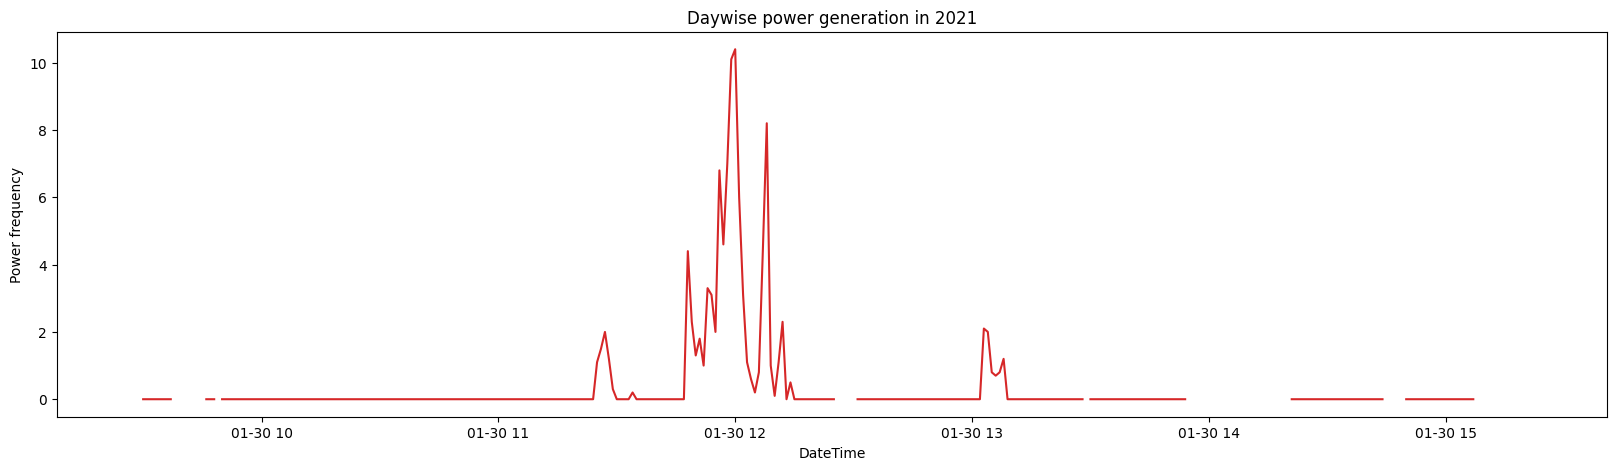

In [20]:
start_date = '2021-01-30'
end_date = '2021-01-31'
mask = (merged_df.datetime > start_date) & (merged_df.datetime <= end_date)
df_mask = merged_df.loc[mask]
print(merged_df.shape)
merged_df = merged_df[~mask]
print(merged_df.shape)
plot_df(df_mask, x=df_mask.datetime, y=df_mask['Solar power'], title='Daywise power generation in 2021')


(165905, 4)
(165485, 4)


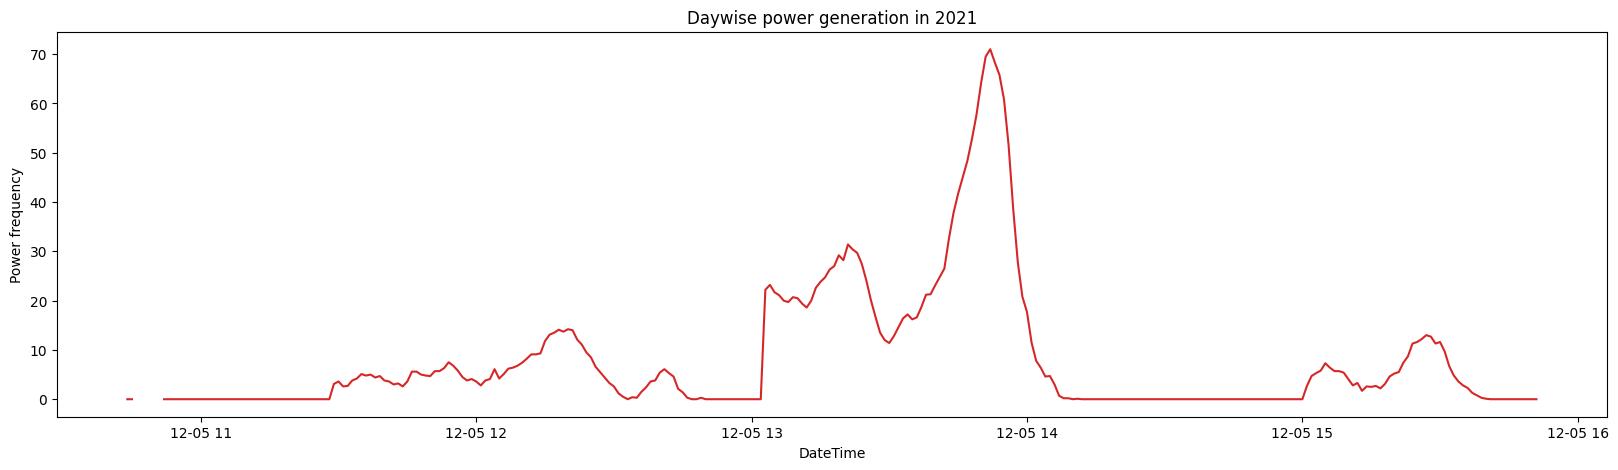

In [21]:
start_date = '2021-12-05'
end_date = '2021-12-06'
mask = (merged_df.datetime > start_date) & (merged_df.datetime <= end_date)
df_mask = merged_df.loc[mask]
print(merged_df.shape)
merged_df = merged_df[~mask]
print(merged_df.shape)
plot_df(df_mask, x=df_mask.datetime, y=df_mask['Solar power'], title='Daywise power generation in 2021')


(165485, 4)
(165065, 4)


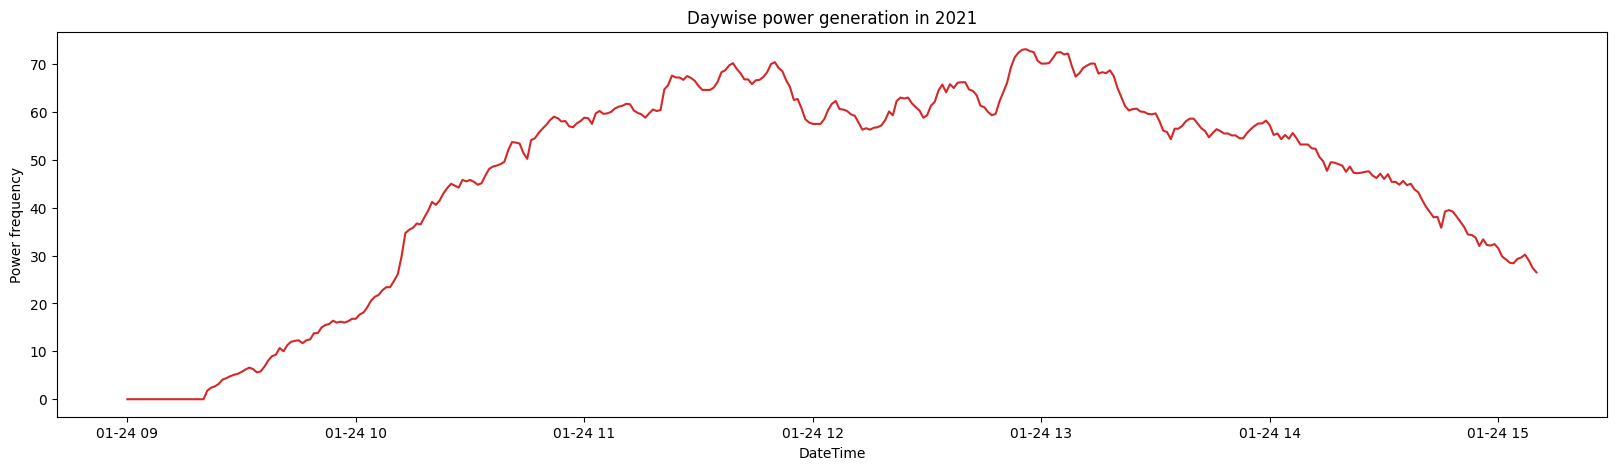

In [22]:
start_date = '2022-01-24'
end_date = '2022-01-25'
mask = (merged_df.datetime > start_date) & (merged_df.datetime <= end_date)
df_mask = merged_df.loc[mask]
print(merged_df.shape)
merged_df = merged_df[~mask]
print(merged_df.shape)
plot_df(df_mask, x=df_mask.datetime, y=df_mask['Solar power'], title='Daywise power generation in 2021')


Dates with Nan values between 9am to 10 am and from 3 pm to 4 pm

In [23]:
nan_df = merged_df[(merged_df.isna().any(axis=1)) & (merged_df['datetime'].dt.hour >= 9) & (merged_df['datetime'].dt.hour < 10)]

nan_dates_9_to_10 = nan_df['datetime'].dt.date.unique()


print(nan_dates_9_to_10)


[datetime.date(2021, 1, 1) datetime.date(2021, 1, 2)
 datetime.date(2021, 1, 3) datetime.date(2021, 1, 5)
 datetime.date(2021, 1, 6) datetime.date(2021, 1, 7)
 datetime.date(2021, 1, 8) datetime.date(2021, 1, 9)
 datetime.date(2021, 1, 11) datetime.date(2021, 1, 31)
 datetime.date(2021, 2, 1) datetime.date(2021, 2, 2)
 datetime.date(2021, 2, 3) datetime.date(2021, 10, 15)
 datetime.date(2021, 12, 2) datetime.date(2021, 12, 12)
 datetime.date(2021, 12, 14) datetime.date(2021, 12, 15)
 datetime.date(2021, 12, 16) datetime.date(2021, 12, 17)
 datetime.date(2021, 12, 19) datetime.date(2021, 12, 23)
 datetime.date(2021, 12, 24) datetime.date(2022, 1, 7)
 datetime.date(2022, 1, 25)]


In [24]:
nan_df = merged_df[(merged_df.isna().any(axis=1)) & (merged_df['datetime'].dt.hour >= 15) & (merged_df['datetime'].dt.hour < 16)]
nan_dates_15_to_16 = nan_df['datetime'].dt.date.unique()

print(nan_dates_15_to_16)


[datetime.date(2021, 1, 5) datetime.date(2021, 1, 7)
 datetime.date(2021, 1, 11) datetime.date(2021, 1, 29)
 datetime.date(2021, 2, 1) datetime.date(2021, 2, 2)
 datetime.date(2021, 11, 15) datetime.date(2021, 11, 16)
 datetime.date(2021, 11, 28) datetime.date(2021, 12, 3)
 datetime.date(2021, 12, 4) datetime.date(2021, 12, 6)
 datetime.date(2021, 12, 9) datetime.date(2021, 12, 10)
 datetime.date(2021, 12, 12) datetime.date(2021, 12, 13)
 datetime.date(2021, 12, 14) datetime.date(2021, 12, 16)
 datetime.date(2021, 12, 17) datetime.date(2021, 12, 18)
 datetime.date(2021, 12, 19) datetime.date(2021, 12, 23)
 datetime.date(2021, 12, 30) datetime.date(2022, 1, 2)]


Fill Nann values with fill forward method

In [25]:
merged_df.fillna(method='ffill', inplace=True)
merged_df.fillna(0, inplace=True)
# Verify the updated merged_df
print(merged_df.tail())

              Date   Time  Solar power            datetime
275524  31-01-2022  15:55         66.6 2022-01-31 15:55:00
275525  31-01-2022  15:56         83.5 2022-01-31 15:56:00
275526  31-01-2022  15:57        117.8 2022-01-31 15:57:00
275527  31-01-2022  15:58        178.7 2022-01-31 15:58:00
275528  31-01-2022  15:59        159.6 2022-01-31 15:59:00


Filled values plot

(420, 4)


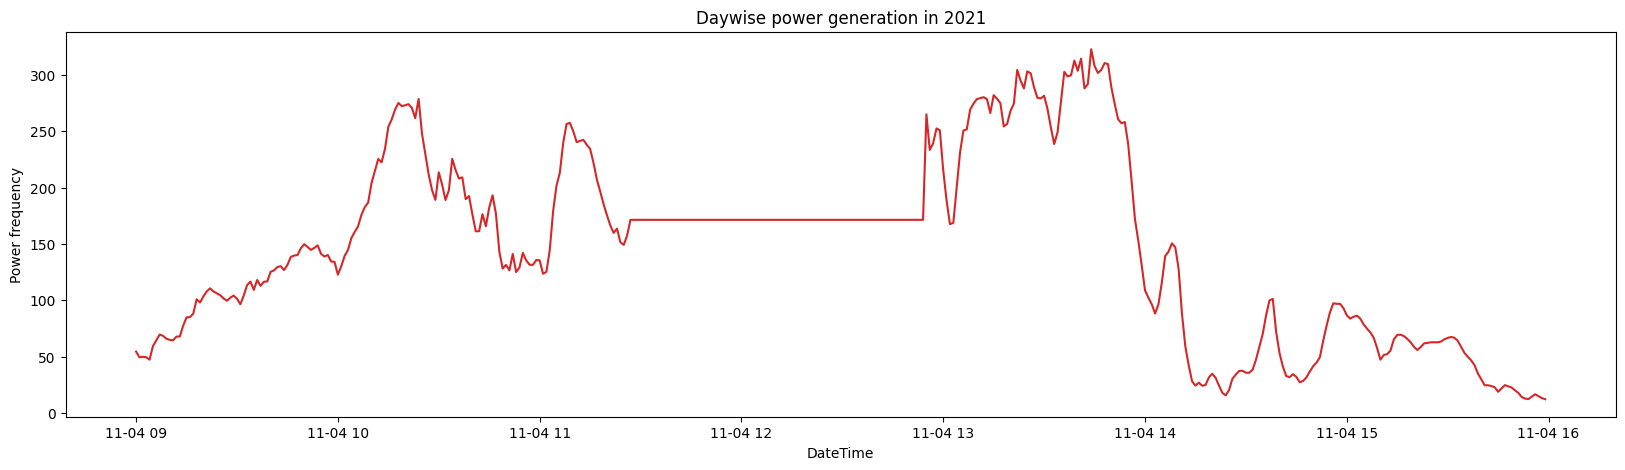

In [26]:
start_date = '2021-11-04'
end_date = '2021-11-05'
mask = (merged_df.datetime > start_date) & (merged_df.datetime <= end_date)
df_mask = merged_df.loc[mask]
print(df_mask.shape)
plot_df(df_mask, x=df_mask.datetime, y=df_mask['Solar power'], title='Daywise power generation in 2021')


(420, 4)


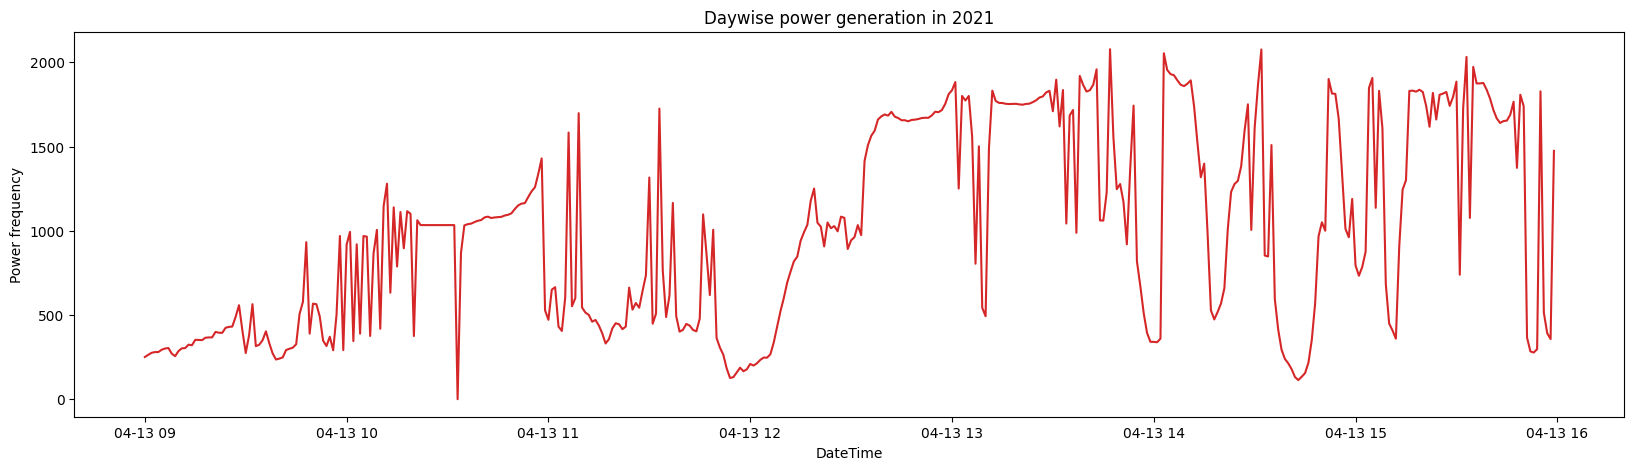

In [27]:
start_date = '2021-04-13'
end_date = '2021-04-14'
mask = (merged_df.datetime > start_date) & (merged_df.datetime <= end_date)
df_mask = merged_df.loc[mask]
print(df_mask.shape)
plot_df(df_mask, x=df_mask.datetime, y=df_mask['Solar power'], title='Daywise power generation in 2021')


(425, 4)


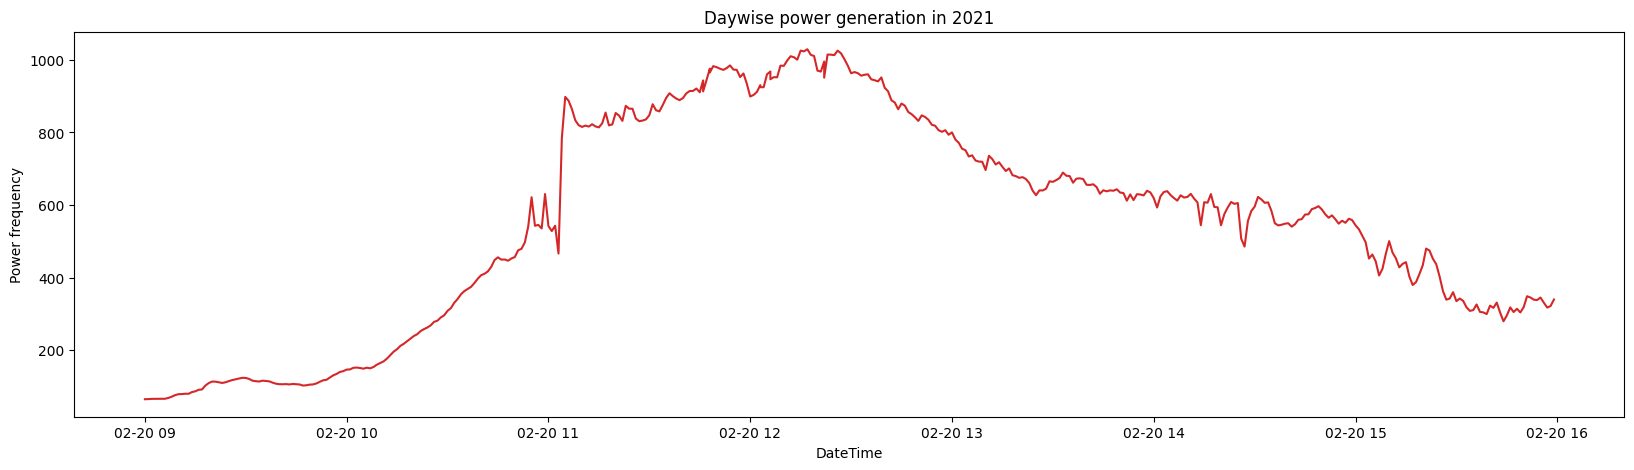

In [28]:
start_date = '2021-02-20'
end_date = '2021-02-21'
mask = (merged_df.datetime > start_date) & (merged_df.datetime <= end_date)
df_mask = merged_df.loc[mask]
print(df_mask.shape)
plot_df(df_mask, x=df_mask.datetime, y=df_mask['Solar power'], title='Daywise power generation in 2021')


(420, 4)


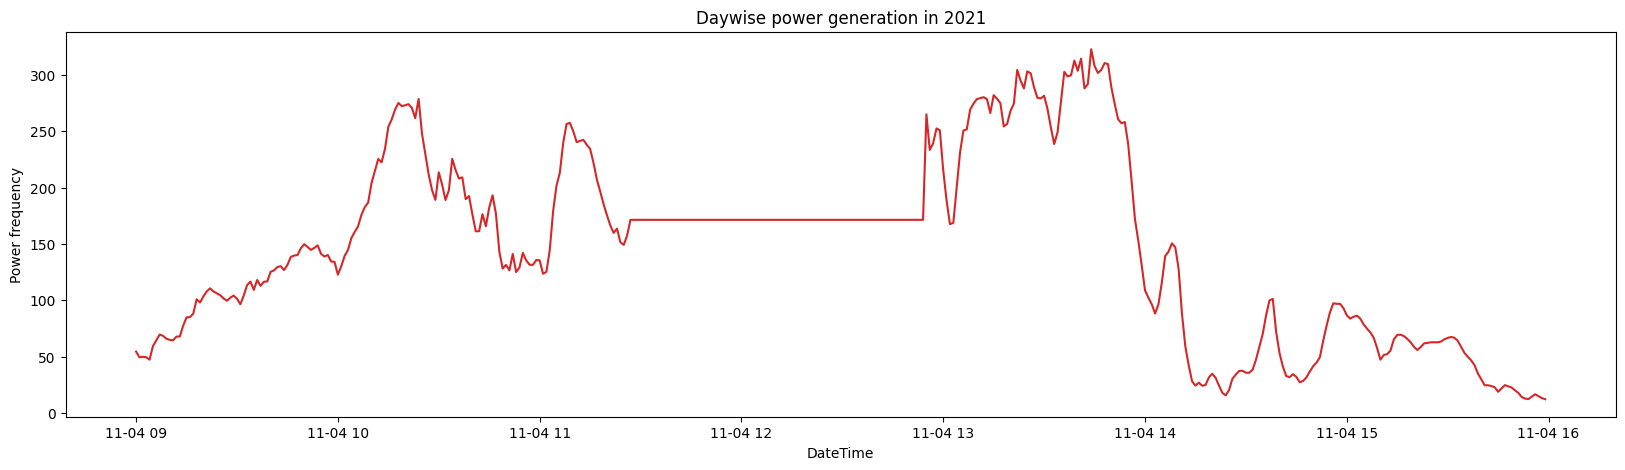

In [29]:
start_date = '2021-11-04'
end_date = '2021-11-05'
mask = (merged_df.datetime > start_date) & (merged_df.datetime <= end_date)
df_mask = merged_df.loc[mask]
print(df_mask.shape)
plot_df(df_mask, x=df_mask.datetime, y=df_mask['Solar power'], title='Daywise power generation in 2021')


In [30]:
nan_df = merged_df[merged_df['Solar power'].isna() & (merged_df['datetime'].dt.hour >= 9) & (merged_df['datetime'].dt.hour < 16)]
nan_dates = nan_df['datetime'].dt.date.unique()

print(nan_dates)

[]


In [31]:
print(merged_df[merged_df["Solar power"].isna()])

Empty DataFrame
Columns: [Date, Time, Solar power, datetime]
Index: []


Plot whole dataset

(165065, 4)


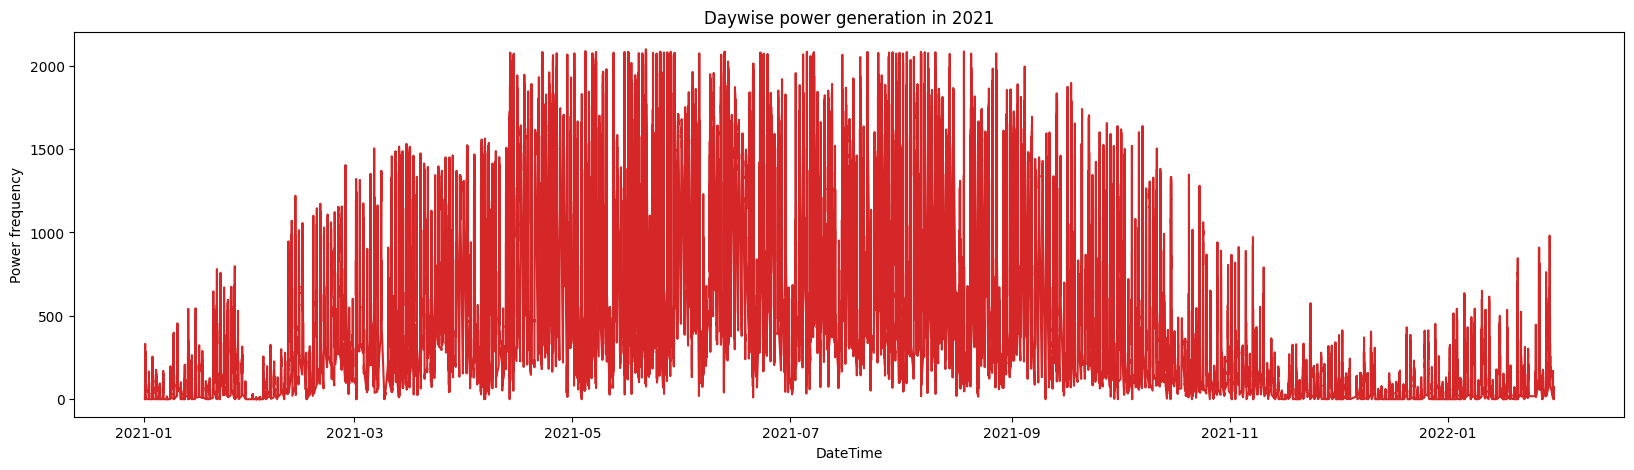

In [32]:
start_date = '2021-01-01'
end_date = '2022-01-31'
mask = (merged_df.datetime > start_date) & (merged_df.datetime <= end_date)
df_mask = merged_df.loc[mask]
print(merged_df.shape)

plot_df(df_mask, x=df_mask.datetime, y=df_mask['Solar power'], title='Daywise power generation in 2021')


Seasonal basis solar generation

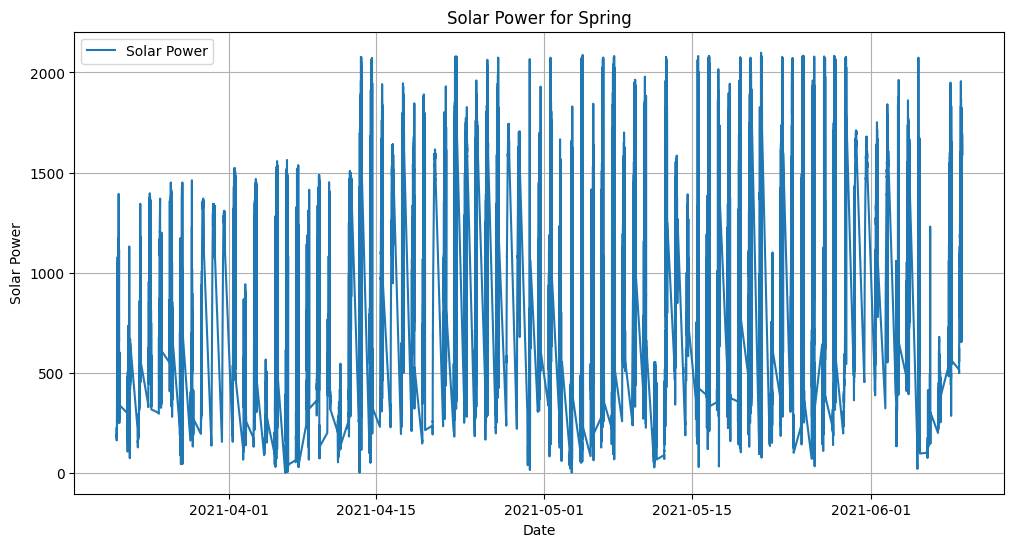

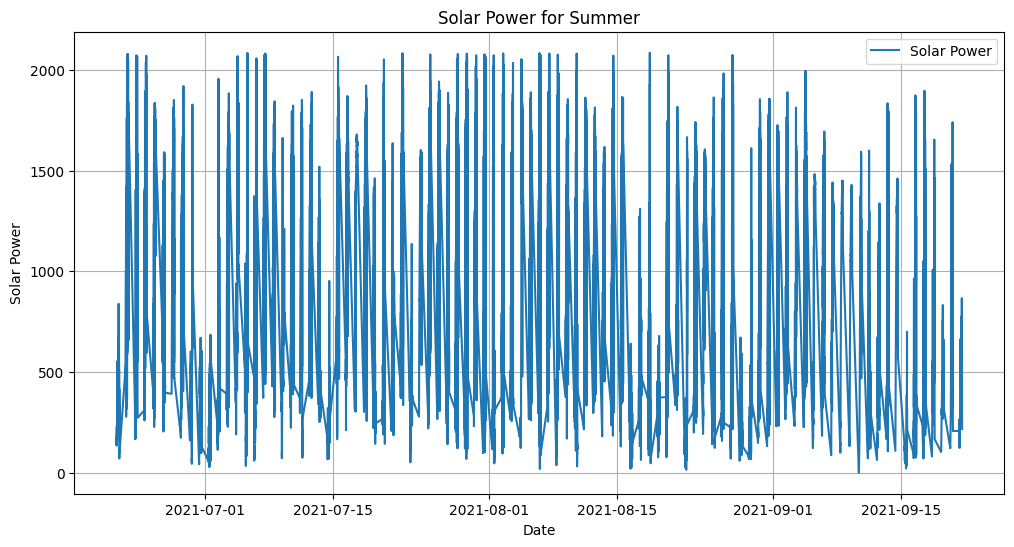

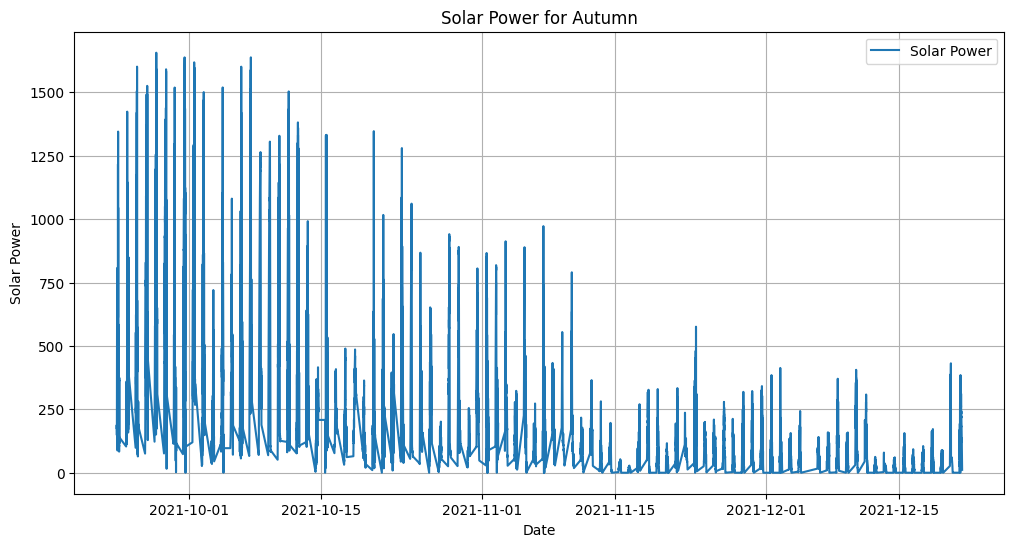

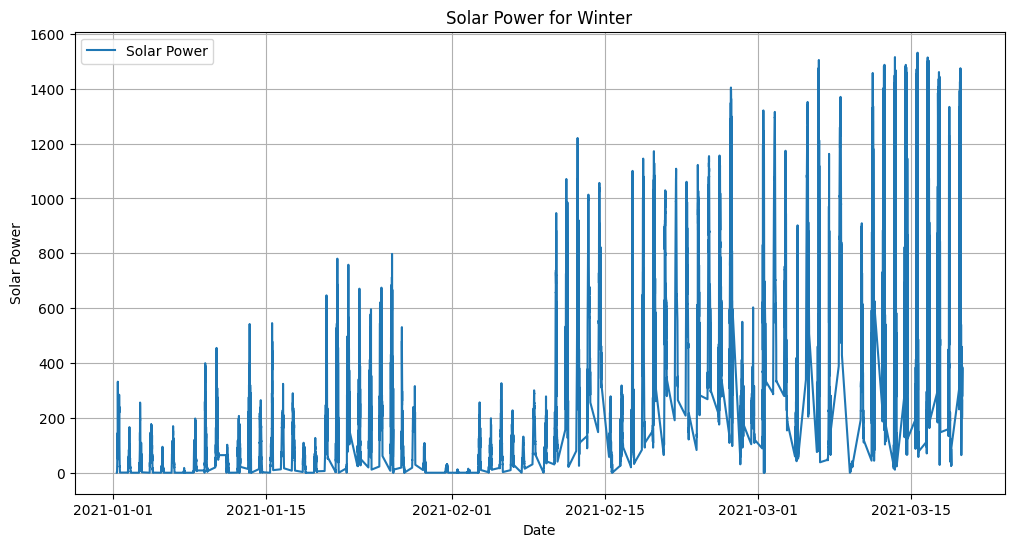

In [33]:
# Define the date ranges for each season
seasons = {

    'Spring': ('2021-03-21', '2021-06-10'),
    'Summer': ('2021-06-21', '2021-09-22'),
    'Autumn': ('2021-09-23', '2021-12-22'),
    'Winter': ('2021-01-01', '2021-03-20')
}

# Create a function to plot data for a given season
def plot_season_data(df, season):
    start_date, end_date = seasons[season]
    mask = (df['datetime'] >= start_date) & (df['datetime'] <= end_date)
    season_df = df.loc[mask]
    plt.figure(figsize=(12, 6))
    plt.plot(season_df['datetime'], season_df['Solar power'], label='Solar Power')
    plt.xlabel('Date')
    plt.ylabel('Solar Power')
    plt.title(f'Solar Power for {season}')
    plt.legend()
    plt.grid(True)
    plt.show()
start_date = '2021-01-01'
end_date = '2021-12-31'
mask = (merged_df.datetime > start_date) & (merged_df.datetime <= end_date)
df_mask = merged_df.loc[mask]

# Iterate over seasons and plot data for each season
for season, (start_date, end_date) in seasons.items():
    mask = (df_mask['datetime'] >= start_date) & (df_mask['datetime'] <= end_date)
    season_df = df_mask.loc[mask]
    dates = season_df['datetime']
    solar_power = season_df['Solar power']
    plot_season_data(season_df, season)


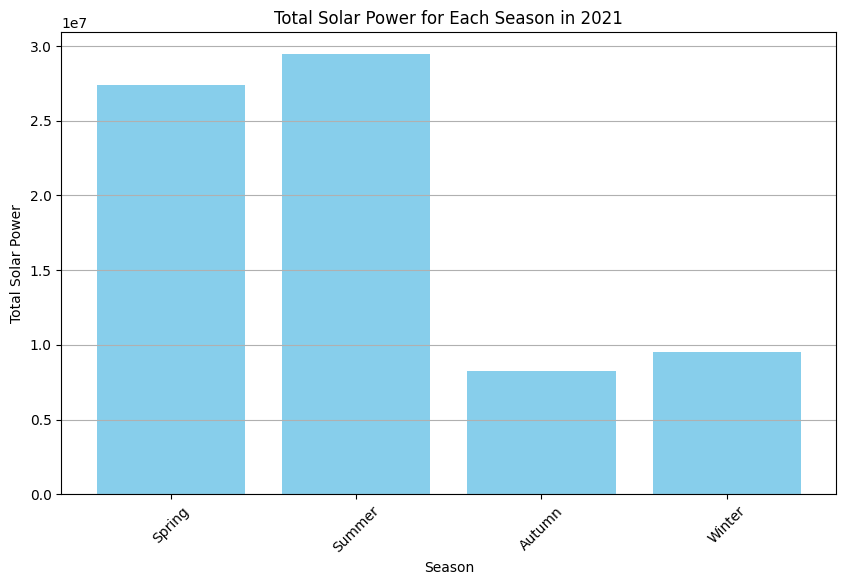

In [34]:
# Define the date ranges for each season
seasons = {

    'Spring': ('2021-03-21', '2021-06-10'),
    'Summer': ('2021-06-21', '2021-09-22'),
    'Autumn': ('2021-09-23', '2021-12-22'),
    'Winter': ('2021-01-01', '2021-03-20')
}

# Aggregate solar power for each season
seasonal_solar_power = {}
start_date = '2021-01-01'
end_date = '2021-12-31'
mask = (merged_df.datetime > start_date) & (merged_df.datetime <= end_date)
df_mask = merged_df.loc[mask]
for season, (start_date, end_date) in seasons.items():
    mask = (df_mask['datetime'] >= start_date) & (df_mask['datetime'] <= end_date)
    season_df = df_mask.loc[mask]
    seasonal_solar_power[season] = season_df['Solar power'].sum()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(seasonal_solar_power.keys(), seasonal_solar_power.values(), color='skyblue')
plt.xlabel('Season')
plt.ylabel('Total Solar Power')
plt.title('Total Solar Power for Each Season in 2021')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


As we see that records every minute each day so, we have to groupby data on minutes to form on hourly basis

In [35]:
merged_df1 = merged_df.groupby([merged_df['datetime'].dt.year, merged_df['datetime'].dt.month, merged_df['datetime'].dt.day, merged_df['datetime'].dt.hour], as_index=True).agg({
    'Solar power': 'sum'
})

# Print the first 11 rows
print(merged_df1.head(17))

                                     Solar power
datetime datetime datetime datetime             
2021     1        1        9               708.0
                           10             5416.5
                           11             8661.0
                           12            11729.2
                           13             9282.2
                           14            11537.7
                           15             1541.8
                  2        9               443.9
                           10             2210.0
                           11             3750.4
                           12             5448.3
                           13             3743.4
                           14             1658.9
                           15              342.5
                  3        9               345.0
                           10             1457.1
                           11             5827.1


In [36]:
merged_df1.tail()


Solar power
datetime datetime datetime datetime             
2022     1        31       11            25043.2
                           12            22139.3
                           13            30731.0
                           14            31254.4
                           15            16934.2

This is what we grouping the data on a year of month of day of hour by applying summation to form data as expected

In [37]:
print(merged_df1['Solar power'])

datetime  datetime  datetime  datetime
2021      1         1         9             708.0
                              10           5416.5
                              11           8661.0
                              12          11729.2
                              13           9282.2
                                           ...   
2022      1         31        11          25043.2
                              12          22139.3
                              13          30731.0
                              14          31254.4
                              15          16934.2
Name: Solar power, Length: 2751, dtype: float64


In [38]:
df1 = pd.DataFrame({'year':[i for i,j,k,l in merged_df1.index],
                  'month':[j for i,j,k,l in merged_df1.index],
                  'day':[k for i,j,k,l in merged_df1.index],
                  'hour':[l for i,j,k,l in merged_df1.index]})
df1 = pd.to_datetime(df1)
df1

0      2021-01-01 09:00:00
1      2021-01-01 10:00:00
2      2021-01-01 11:00:00
3      2021-01-01 12:00:00
4      2021-01-01 13:00:00
               ...        
2746   2022-01-31 11:00:00
2747   2022-01-31 12:00:00
2748   2022-01-31 13:00:00
2749   2022-01-31 14:00:00
2750   2022-01-31 15:00:00
Length: 2751, dtype: datetime64[ns]

In [39]:
columns = ["Solar power"]

df2 = pd.DataFrame({'datetime': df1, 'Solar power': [i for i in merged_df1['Solar power']]})
df2.tail()

datetime  Solar power
2746 2022-01-31 11:00:00      25043.2
2747 2022-01-31 12:00:00      22139.3
2748 2022-01-31 13:00:00      30731.0
2749 2022-01-31 14:00:00      31254.4
2750 2022-01-31 15:00:00      16934.2

Create Nan dataframe to include the eliminated days and fill their value with interpolation

In [40]:

# create date range
start_date = dt.datetime(2021, 1, 1)
end_date = dt.datetime(2022, 1, 31)
dates = pd.date_range(start_date, end_date)

# create time range from 8:00 to 15:00 every minute
start_time = dt.datetime.strptime('9:00:00', '%H:%M:%S').time()
end_time = dt.datetime.strptime('16:00:00', '%H:%M:%S').time()
times = pd.date_range(start_date, end_date + dt.timedelta(days=1), freq='H').time
#print(times)
times = [t for t in times if t >= start_time and t < end_time]
#print("1",times)
# create list of rows

rows = [[dt.datetime.combine(date, time),np.nan]
        for date in dates for time in times]
columns = ['datetime', 'Solar power']
# create dataframe

df4 = pd.DataFrame(rows, columns=columns)


df4 = df4.drop_duplicates(subset=['datetime'])

df4.tail()


datetime  Solar power
1094942 2022-01-31 11:00:00          NaN
1094943 2022-01-31 12:00:00          NaN
1094944 2022-01-31 13:00:00          NaN
1094945 2022-01-31 14:00:00          NaN
1094946 2022-01-31 15:00:00          NaN

In [41]:
merged_df3 = pd.concat([df4, df2], axis=0)
merged_df3 = merged_df3.sort_values(by='datetime')
print(merged_df3.shape)
merged_df3 = merged_df3[((merged_df3['datetime'].shift() != merged_df3['datetime']) &
                       (merged_df3['datetime'].shift(-1) != merged_df3['datetime'])|
                       (merged_df3['Solar power'].notna()))]
print(merged_df3.shape)


(5523, 2)
(2772, 2)


In [42]:
merged_df3['datetime'] = pd.to_datetime(merged_df3['datetime'])

# set datetime as index
merged_df3.set_index('datetime', inplace=True)

# group dataframe by date
grouped = merged_df3.groupby(merged_df3.index.time, group_keys=False)

# interpolate missing values
merged_df3 = grouped.apply(lambda group: group.interpolate())

# reset index
merged_df3.reset_index(inplace=True)


In [43]:
print(merged_df3.isna().sum())


datetime       0
Solar power    0
dtype: int64


Whole Solar power on hourly basis

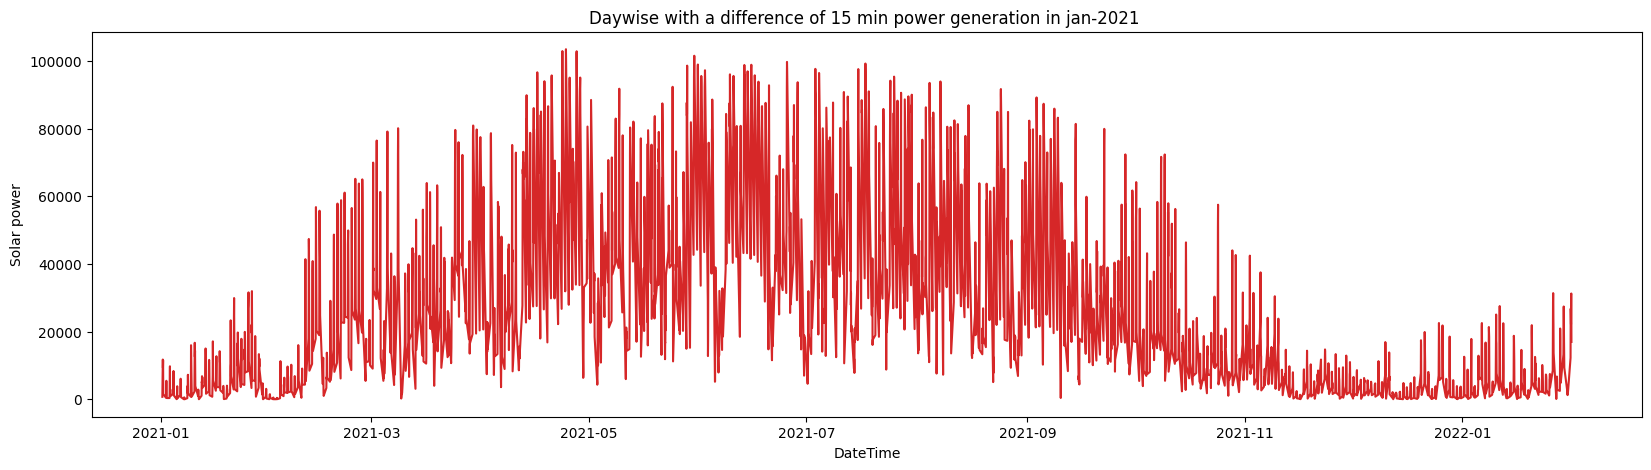

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

# Draw Plot
def plot_df(df, x, y, title="", xlabel='DateTime', ylabel='Solar power', dpi=100):
    plt.figure(figsize=(20,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(merged_df3, x=merged_df3['datetime'], y=merged_df3['Solar power'], title='Daywise with a difference of 15 min power generation in jan-2021 ')


Check if we have outlinears

In [45]:
mean_solar_power = merged_df3['Solar power'].mean()
max_solar_power = merged_df3['Solar power'].max()
min_solar_power = merged_df3['Solar power'].min()

# Print the calculated values
print('Mean Solar Power:', mean_solar_power)
print('Max Solar Power:', max_solar_power)
print('Min Solar Power:', min_solar_power)

Mean Solar Power: 29881.21084054834
Max Solar Power: 103477.9
Min Solar Power: 0.0


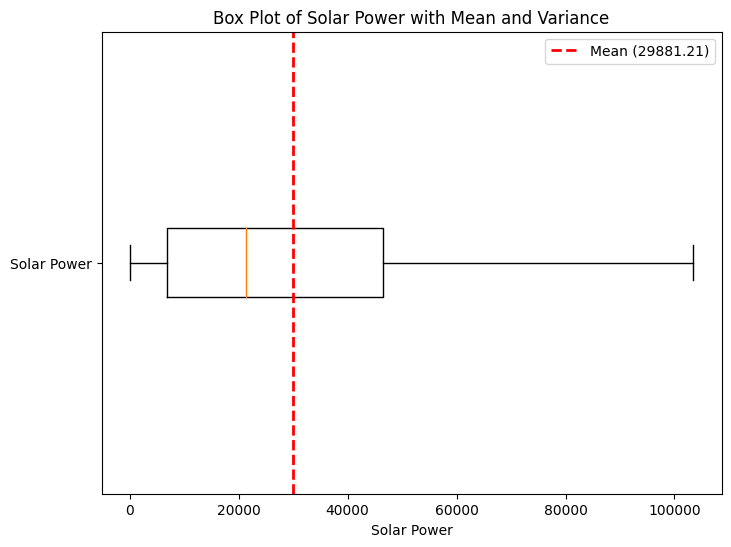

Mean Solar Power: 29881.21084054834
Variance Solar Power: 731879607.7902946


In [46]:

import matplotlib.pyplot as plt

# Assuming merged_df is the DataFrame you want to use

# Calculate mean and variance of Solar power
mean_solar_power = merged_df3['Solar power'].mean()
variance_solar_power = merged_df3['Solar power'].var()

# Create a box plot for Solar power
plt.figure(figsize=(8, 6))
plt.boxplot(merged_df3['Solar power'], vert=False, labels=['Solar Power'])
plt.axvline(mean_solar_power, color='r', linestyle='dashed', linewidth=2, label=f'Mean ({mean_solar_power:.2f})')
plt.title('Box Plot of Solar Power with Mean and Variance')
plt.xlabel('Solar Power')
plt.legend()
plt.show()

# Print the calculated mean and variance
print('Mean Solar Power:', mean_solar_power)
print('Variance Solar Power:', variance_solar_power)


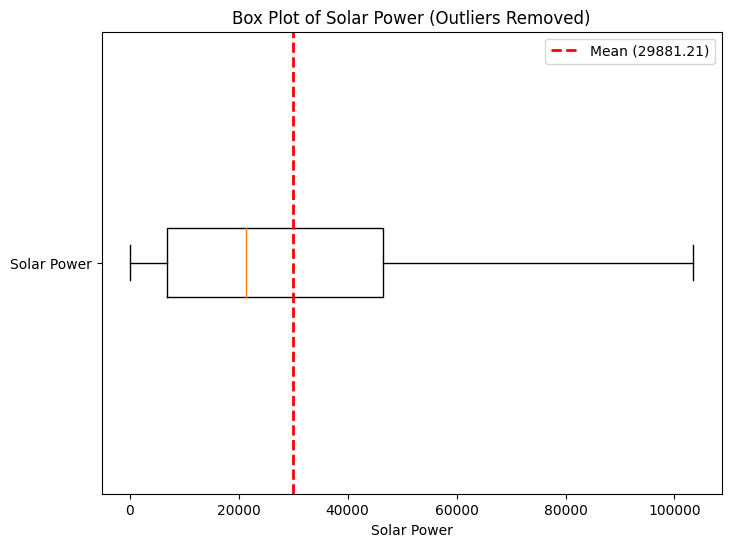

Mean Solar Power (after removing outliers): 29881.21084054834
Number of Outliers Removed: 0


In [47]:

import matplotlib.pyplot as plt
import numpy as np

# Assuming merged_df is the DataFrame you want to use

# Calculate the quartiles for Solar power
q1 = merged_df3['Solar power'].quantile(0.25)
q3 = merged_df3['Solar power'].quantile(0.75)
iqr = q3 - q1

# Define the lower and upper bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identify outliers and create a mask
outlier_mask = (merged_df3['Solar power'] < lower_bound) | (merged_df3['Solar power'] > upper_bound)

# Count the number of outliers before removing
num_outliers_before = np.sum(outlier_mask)

# Filter the DataFrame to include only dates within the box plot's range
filtered_df = merged_df3[(merged_df3['Solar power'] >= lower_bound) & (merged_df3['Solar power'] <= upper_bound)]

# Identify outliers and replace them with NaN
merged_df3.loc[~merged_df3.index.isin(filtered_df.index), 'Solar power'] = np.nan

# Create a box plot for Solar power
plt.figure(figsize=(8, 6))
plt.boxplot(filtered_df['Solar power'], vert=False, labels=['Solar Power'])
plt.axvline(filtered_df['Solar power'].mean(), color='r', linestyle='dashed', linewidth=2, label=f'Mean ({filtered_df["Solar power"].mean():.2f})')
plt.title('Box Plot of Solar Power (Outliers Removed)')
plt.xlabel('Solar Power')
plt.legend()
plt.show()

# Count the number of outliers after removing
num_outliers_after =  np.sum(~merged_df3['Solar power'].notna()) - num_outliers_before

# Print the mean of Solar power after removing outliers
print('Mean Solar Power (after removing outliers):', filtered_df['Solar power'].mean())

# Print the number of outliers removed
print('Number of Outliers Removed:', num_outliers_after)


In [48]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10000)

## Data Preparation

Import weather data

In [49]:
print(merged_df3.shape)
df_weather_actual = pd.read_csv('Data/bremen 2021-01-01 to 2022-01-31.csv')
print(df_weather_actual.shape)

(2772, 2)
(9504, 24)


exclude the hours that are not in the Solar power to have the same length


In [50]:

df_weather_actual['datetime'] = pd.to_datetime(df_weather_actual['datetime'])

# Filter for the specified time frame
start_time = pd.to_datetime("9:00").time()
end_time = pd.to_datetime("16:00").time()

df_weather_actual = df_weather_actual[(df_weather_actual['datetime'].dt.time >= start_time) & (df_weather_actual['datetime'].dt.time < end_time)]

df_weather_actual.shape


(2772, 24)

In [51]:
df_weather_actual.head(2)

name            datetime  temp  feelslike  dew  humidity  precip  \
9   bremen 2021-01-01 09:00:00   0.7        0.7 -0.1     94.45   0.000   
10  bremen 2021-01-01 10:00:00   1.6        1.6  0.7     93.78   0.001   

    precipprob preciptype  snow  snowdepth  windgust  windspeed  winddir  \
9            0        NaN   0.0        0.0       NaN        3.6    220.0   
10         100  rain,snow   0.0        0.0       NaN        4.7    210.0   

    sealevelpressure  cloudcover  visibility  solarradiation  solarenergy  \
9             1006.1        59.8         7.0             3.0          0.0   
10            1006.5        43.9         6.0            14.0          0.1   

    uvindex  severerisk                    conditions               icon  \
9         0         NaN              Partially cloudy  partly-cloudy-day   
10        0         NaN  Snow, Rain, Partially cloudy               rain   

                                     stations  
9   04275,00704,05014,C6054,00691,00044,05822  
10  E8845,04275,00704,05014,00691,00044,05822

In [52]:
start_date = '2021-01-01 9:00:00'
end_date = '2022-01-31 16:00:00'
mask = (df_weather_actual.datetime < start_date) & (df_weather_actual.datetime > end_date)
df_mask = df_weather_actual.loc[mask]

df_weather_actual.drop(df_mask.index, inplace=True)
df_weather_actual.drop('stations', inplace=True, axis=1)

print(df_weather_actual.shape)


(2772, 23)


<ipython-input-52-ab163460beb9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_actual.drop(df_mask.index, inplace=True)
<ipython-input-52-ab163460beb9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_actual.drop('stations', inplace=True, axis=1)


In [53]:
df_weather_actual.head(2)

name            datetime  temp  feelslike  dew  humidity  precip  \
9   bremen 2021-01-01 09:00:00   0.7        0.7 -0.1     94.45   0.000   
10  bremen 2021-01-01 10:00:00   1.6        1.6  0.7     93.78   0.001   

    precipprob preciptype  snow  snowdepth  windgust  windspeed  winddir  \
9            0        NaN   0.0        0.0       NaN        3.6    220.0   
10         100  rain,snow   0.0        0.0       NaN        4.7    210.0   

    sealevelpressure  cloudcover  visibility  solarradiation  solarenergy  \
9             1006.1        59.8         7.0             3.0          0.0   
10            1006.5        43.9         6.0            14.0          0.1   

    uvindex  severerisk                    conditions               icon  
9         0         NaN              Partially cloudy  partly-cloudy-day  
10        0         NaN  Snow, Rain, Partially cloudy               rain

Do some plots to have better insight of weather data

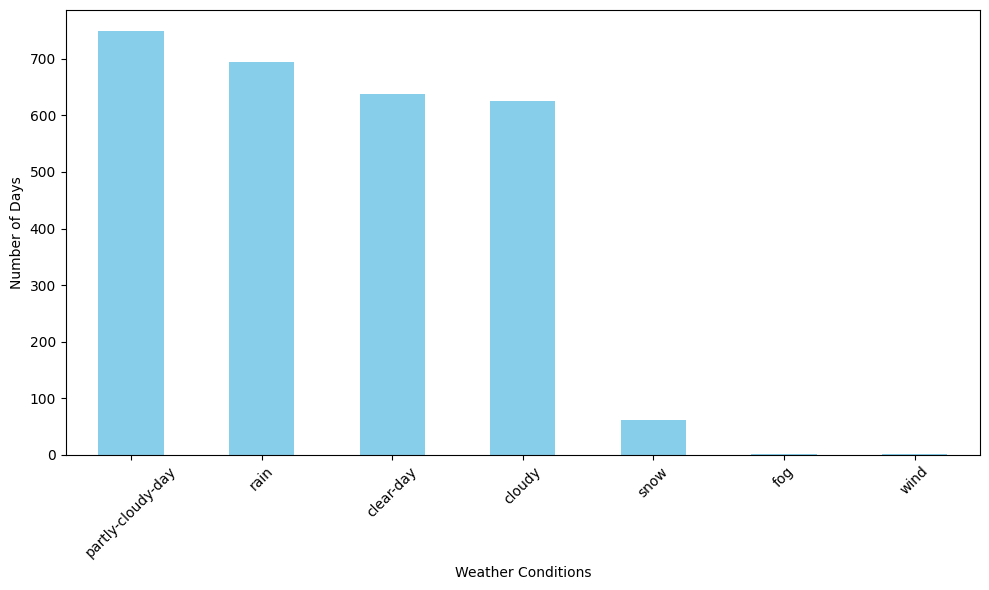

In [54]:
import matplotlib.pyplot as plt

# Count the occurrences of each unique value in the 'icon' column
condition_counts = df_weather_actual['icon'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
condition_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Weather Conditions')
plt.ylabel('Number of Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


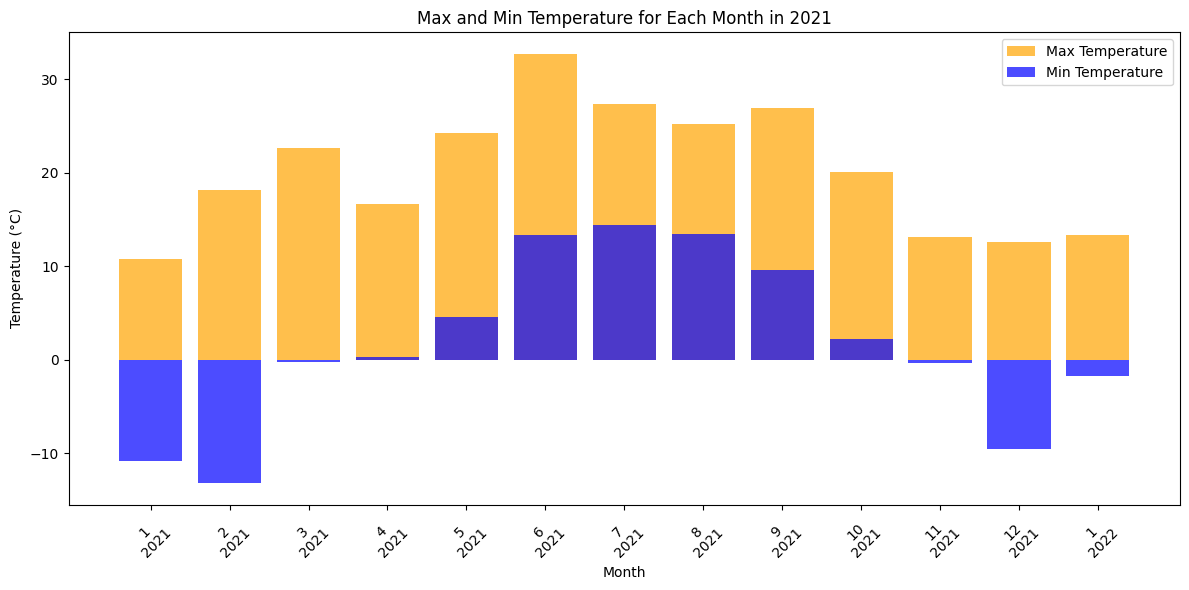

In [55]:
df_weather_actual['datetime'] = pd.to_datetime(df_weather_actual['datetime'])

# Extract month and year
df_weather_actual['month'] = df_weather_actual['datetime'].dt.month
df_weather_actual['year'] = df_weather_actual['datetime'].dt.year

# Group by month and year, and calculate max and min temperatures
monthly_temp = df_weather_actual.groupby(['year', 'month'])['temp'].agg(['max', 'min']).reset_index()

# Plotting the bar chart
plt.figure(figsize=(12, 6))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x_labels = [f'{month}\n{year}' for year, month in zip(monthly_temp['year'], monthly_temp['month'])]
plt.bar(x_labels, monthly_temp['max'], label='Max Temperature', color='orange', alpha=0.7)
plt.bar(x_labels, monthly_temp['min'], label='Min Temperature', color='blue', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Max and Min Temperature for Each Month in 2021')
plt.xticks(x_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
df_weather_actual = df_weather_actual.drop(columns=['month','year'])


now we having some number of rows for features and power

In [56]:
df_weather_actual.dtypes

name                        object
datetime            datetime64[ns]
temp                       float64
feelslike                  float64
dew                        float64
humidity                   float64
precip                     float64
precipprob                   int64
preciptype                  object
snow                       float64
snowdepth                  float64
windgust                   float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
solarradiation             float64
solarenergy                float64
uvindex                      int64
severerisk                 float64
conditions                  object
icon                        object
dtype: object

### Removing null column and rows if any

In [57]:
df_weather_actual.isna().sum()

name                   0
datetime               0
temp                   0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
preciptype          2032
snow                   7
snowdepth              7
windgust            2622
windspeed              0
winddir                0
sealevelpressure      21
cloudcover             0
visibility            27
solarradiation         0
solarenergy            0
uvindex                0
severerisk          2622
conditions             0
icon                   0
dtype: int64

In [58]:
## drop columns having null values as we see above wind_chill, heat_index etc having larger null values
df_weather_actual = df_weather_actual.drop(columns=['preciptype','windgust','severerisk'])
df_weather_actual.shape

(2772, 20)

In [59]:

merged_df5 = df_weather_actual.merge(merged_df3)
df_weather_actual = merged_df5.sort_values(by='datetime')

print(df_weather_actual.tail())
df_weather_actual.shape

        name            datetime  temp  feelslike  dew  humidity  precip  \
2767  bremen 2022-01-31 11:00:00   5.1       -0.1  1.2     75.41   0.005   
2768  bremen 2022-01-31 12:00:00   6.1        1.7  1.5     72.71   0.000   
2769  bremen 2022-01-31 13:00:00   6.0        1.8  1.7     73.55   0.772   
2770  bremen 2022-01-31 14:00:00   6.3        1.2  1.2     69.98   0.055   
2771  bremen 2022-01-31 15:00:00   7.0        2.4  1.6     68.49   0.005   

      precipprob  snow  snowdepth  windspeed  winddir  sealevelpressure  \
2767         100   0.0        0.0       34.2    280.0            1016.9   
2768           0   0.0        0.0       26.6    280.0            1017.6   
2769         100   0.0        0.0       25.2    300.0            1018.6   
2770         100   0.0        0.0       36.3    290.0            1019.2   
2771         100   0.0        0.0       33.4    300.0            1020.2   

      cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2767         5.0      

(2772, 21)

In [60]:
print(df_weather_actual.isna().sum())
df_weather_actual.shape

name                 0
datetime             0
temp                 0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
snow                 7
snowdepth            7
windspeed            0
winddir              0
sealevelpressure    21
cloudcover           0
visibility          27
solarradiation       0
solarenergy          0
uvindex              0
conditions           0
icon                 0
Solar power          0
dtype: int64


(2772, 21)

replace the rest of missing values

In [61]:
num_cols = ["snow","snowdepth","visibility", "sealevelpressure","Solar power"]

In [62]:
def replace_missing_numeral(cols):
    for col in cols:
        med = df_weather_actual[col].median()
        df_weather_actual[col].replace(to_replace = np.nan, value =med, inplace=True)

replace_missing_numeral(num_cols)

Split the test data from the rest

In [63]:
# Set datetime as index
df_weather_actual.set_index('datetime', inplace=True)

# Filter data for January 2021
start_date1 = pd.Timestamp('2022-01-01')
end_date1 = pd.Timestamp('2022-01-31')

df_weather_forecast = df_weather_actual.loc[(df_weather_actual.index >= start_date1) & (df_weather_actual.index <= end_date1)]

# Filter data for January 2021
start_date = pd.Timestamp('2021-01-01')
end_date = pd.Timestamp('2021-12-31')

df_weather_actual = df_weather_actual.loc[(df_weather_actual.index >= start_date) & (df_weather_actual.index <= end_date)]

# Reset datetime as a column
df_weather_actual.reset_index(inplace=True)
df_weather_forecast.reset_index(inplace=True)


In [64]:
print("forcaste dates",df_weather_forecast.shape)
print("actual",df_weather_actual.shape)

forcaste dates (210, 21)
actual (2548, 21)


In [65]:
df_weather_actual.to_csv('weather_actuals_prepared1.csv', index = False, header = True)

In [66]:
df_weather_forecast.to_csv('weather_forecast.csv', index = False, header = True)

In [67]:
df_weather_forecast.head(2)

datetime    name  temp  feelslike   dew  humidity  precip  \
0 2022-01-01 09:00:00  bremen  11.6       11.6  10.2     90.58     0.0   
1 2022-01-01 10:00:00  bremen  11.8       11.8  10.1     88.90     0.0   

   precipprob  snow  snowdepth  windspeed  winddir  sealevelpressure  \
0           0   0.0        0.0       17.3    240.0            1022.4   
1           0   0.0        0.0       19.4    240.0            1022.6   

   cloudcover  visibility  solarradiation  solarenergy  uvindex conditions  \
0        97.7         6.0             6.0          0.0        0   Overcast   
1        96.7         8.0            19.0          0.1        0   Overcast   

     icon  Solar power  
0  cloudy        690.1  
1  cloudy       2489.7

Discribe df_weather_actual features

In [68]:
df_weather_actual.describe()

temp    feelslike          dew     humidity       precip  \
count  2548.000000  2548.000000  2548.000000  2548.000000  2548.000000   
mean     11.175275     9.708399     6.617739    75.278046     0.079059   
std       7.496525     9.037046     6.365520    14.583562     0.419593   
min     -13.200000   -17.100000   -14.700000    29.300000     0.000000   
25%       5.500000     2.200000     1.900000    64.817500     0.000000   
50%      11.000000    11.000000     6.700000    77.045000     0.000000   
75%      17.300000    17.300000    12.100000    87.320000     0.000000   
max      32.700000    32.400000    20.300000   100.000000     8.802000   

        precipprob         snow    snowdepth    windspeed      winddir  \
count  2548.000000  2548.000000  2548.000000  2548.000000  2548.000000   
mean     24.882261     0.002488     0.266574    16.426962   207.109890   
std      43.241566     0.024229     1.308954     8.330189    85.536881   
min       0.000000     0.000000     0.000000     0.700000     9.000000   
25%       0.000000     0.000000     0.000000    10.400000   140.000000   
50%       0.000000     0.000000     0.000000    14.800000   220.000000   
75%       0.000000     0.000000     0.000000    21.200000   270.000000   
max     100.000000     0.370000    10.890000    51.300000   360.000000   

       sealevelpressure   cloudcover   visibility  solarradiation  \
count       2548.000000  2548.000000  2548.000000     2548.000000   
mean        1015.647135    56.952630    23.117268      239.839246   
std            9.936979    36.770694    12.452471      223.943962   
min          982.000000     0.000000     0.000000        2.000000   
25%         1009.375000    17.200000    12.100000       63.000000   
50%         1016.600000    63.900000    22.100000      161.000000   
75%         1022.800000    94.200000    30.100000      369.250000   
max         1042.800000   100.000000    50.000000      972.000000   

       solarenergy      uvindex    Solar power  
count  2548.000000  2548.000000    2548.000000  
mean      0.863422     2.378728   31827.269290  
std       0.807520     2.285435   27284.782753  
min       0.000000     0.000000       0.000000  
25%       0.200000     1.000000    8334.625000  
50%       0.600000     2.000000   23908.600000  
75%       1.300000     4.000000   49395.425000  
max       3.500000    10.000000  103477.900000

## Exploratory data analysis

(2548, 21)


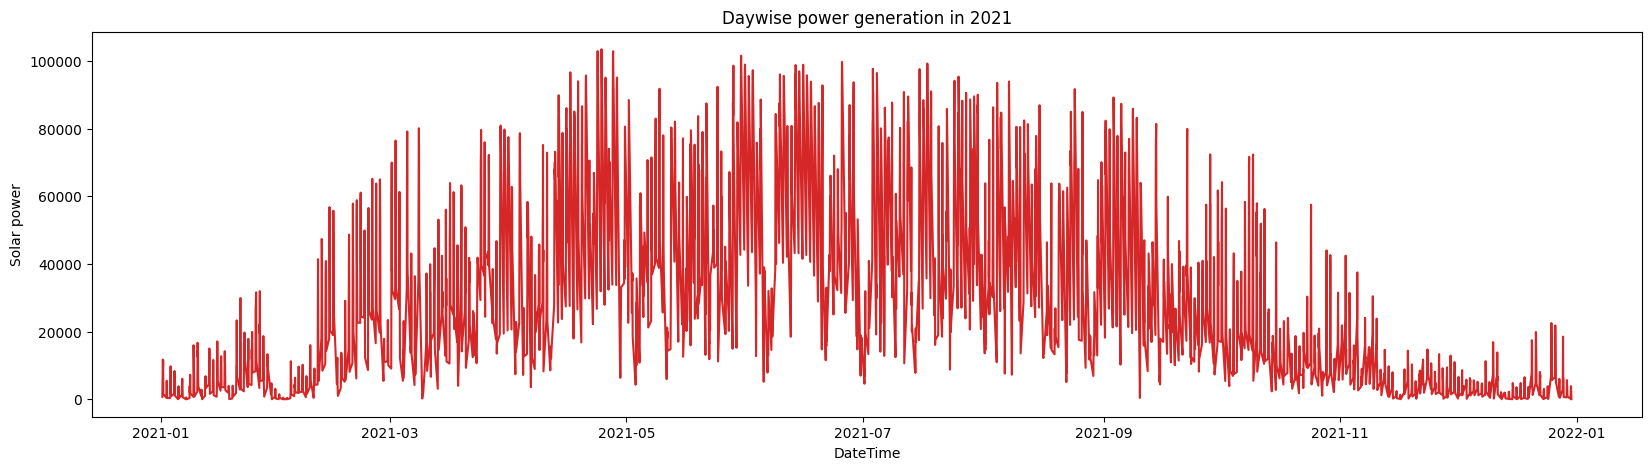

In [69]:
start_date = '2021-01-01'
end_date = '2022-11-30'
mask = (df_weather_actual.datetime > start_date) & (df_weather_actual.datetime <= end_date)
df_mask = df_weather_actual.loc[mask]
print(df_mask.shape)
plot_df(df_mask, x=df_mask.datetime, y=df_mask['Solar power'], title='Daywise power generation in 2021')

### EDA for numerical features

In [70]:
num_cols = ["solarradiation","solarenergy", "uvindex","feelslike","temp", "dew", "winddir","visibility", "sealevelpressure"]


<ipython-input-71-651bd929043b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_weather_actual[col], bins = bins, rug=True, hist = hist)


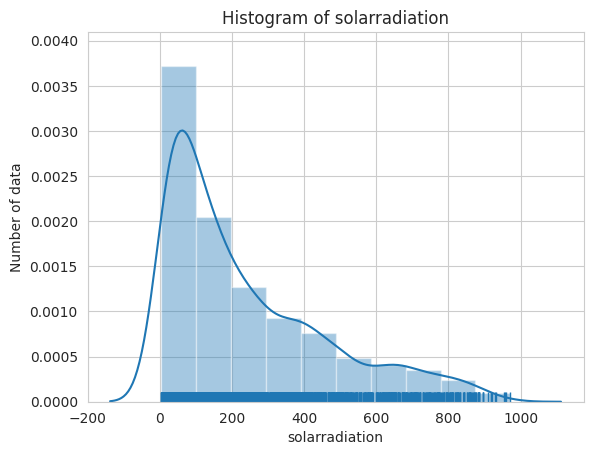

<ipython-input-71-651bd929043b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_weather_actual[col], bins = bins, rug=True, hist = hist)


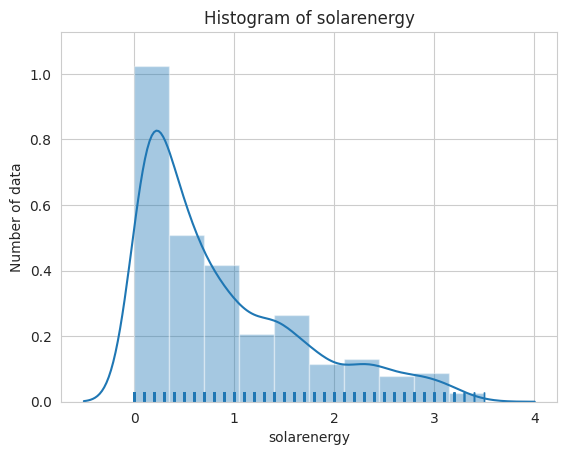

<ipython-input-71-651bd929043b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_weather_actual[col], bins = bins, rug=True, hist = hist)


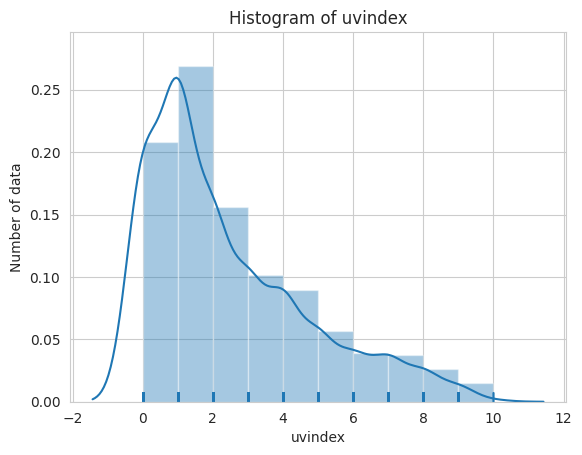

<ipython-input-71-651bd929043b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_weather_actual[col], bins = bins, rug=True, hist = hist)


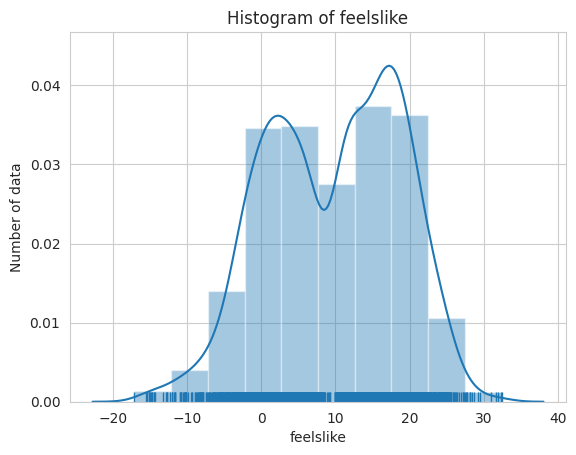

<ipython-input-71-651bd929043b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_weather_actual[col], bins = bins, rug=True, hist = hist)


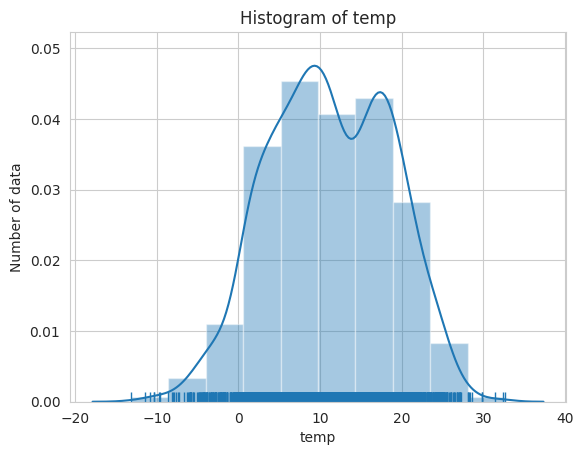

<ipython-input-71-651bd929043b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_weather_actual[col], bins = bins, rug=True, hist = hist)


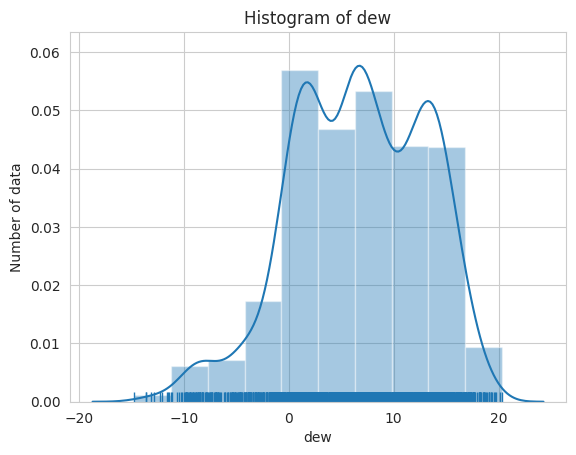

<ipython-input-71-651bd929043b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_weather_actual[col], bins = bins, rug=True, hist = hist)


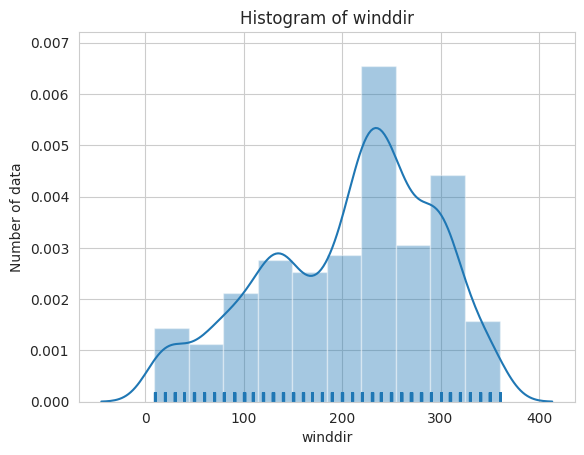

<ipython-input-71-651bd929043b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_weather_actual[col], bins = bins, rug=True, hist = hist)


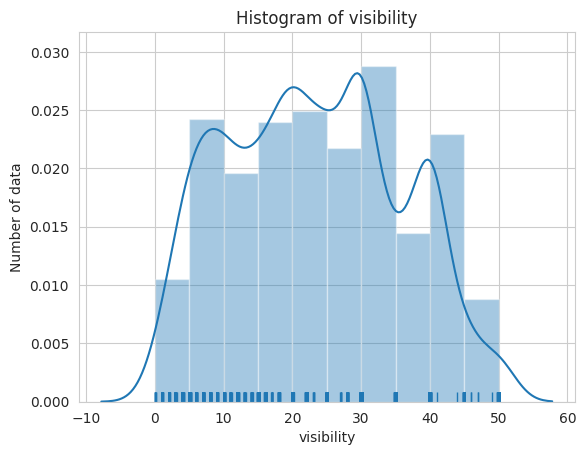

<ipython-input-71-651bd929043b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_weather_actual[col], bins = bins, rug=True, hist = hist)


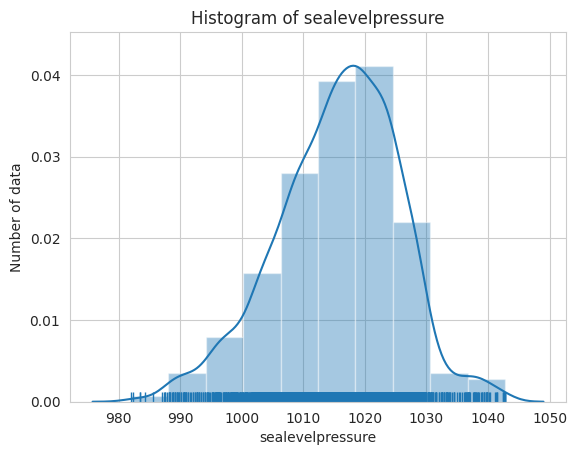

In [71]:
def plot_density_hist(df_weather_actual, cols, bins = 10, hist = False):
    for col in cols:
        sns.set_style("whitegrid")
        sns.distplot(df_weather_actual[col], bins = bins, rug=True, hist = hist)
        plt.title('Histogram of ' + col) # Give the plot a main title
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel('Number of data')# Set text for y axis
        plt.show()

plot_density_hist(df_weather_actual, num_cols, hist=True)

<ipython-input-72-2fa0f1eac1a3>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vals)


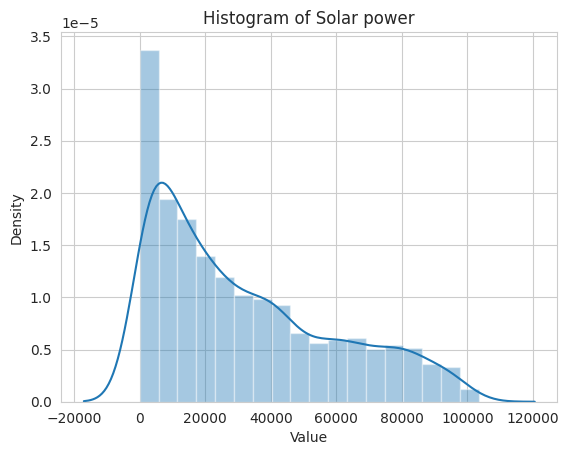

In [72]:
def hist_plot(vals, lab):
    ## Distribution plot of values
    sns.distplot(vals)
    plt.title('Histogram of ' + lab)
    plt.xlabel('Value')
    plt.ylabel('Density')

#labels = np.array(auto_prices['price'])
hist_plot(df_weather_actual['Solar power'], 'Solar power')

here we see power generation is highly right skewed

### EDA for categorical features

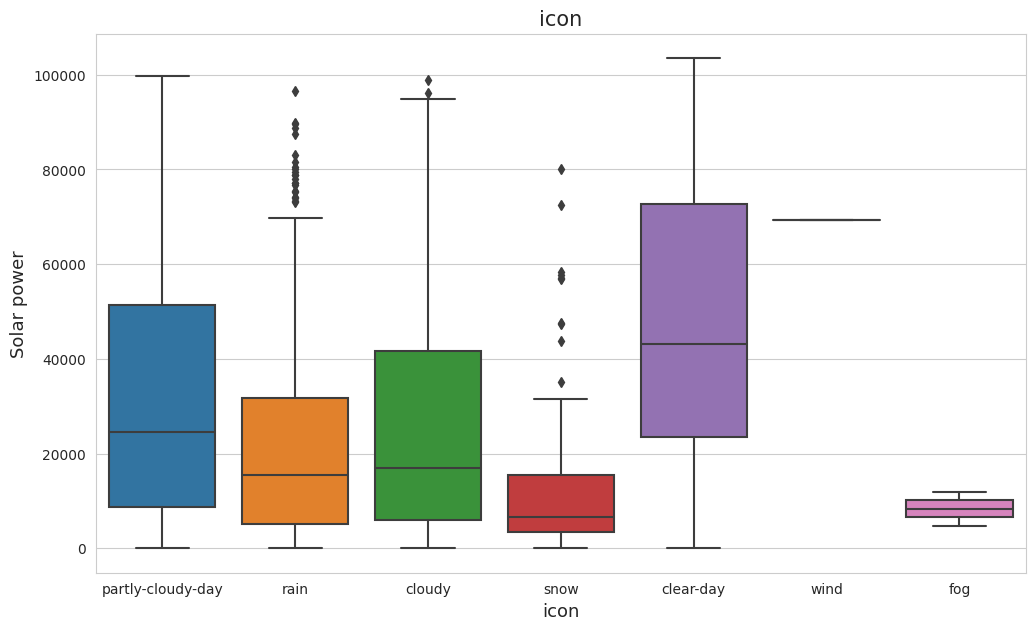

In [73]:
def plot_box(df, cat_cols, col_y='Solar power'):
    for col in cat_cols:
        fig = plt.figure(figsize=(12,7))
        ax = sns.boxplot(x=col, y=col_y, data=df, orient='v')
        ax.set_title(col, fontsize=15)
        ax.set_xlabel(col, fontsize=13)
        ax.set_ylabel(col_y, fontsize=13)

cat_cols = ['icon']
plot_box(df_weather_actual, cat_cols)

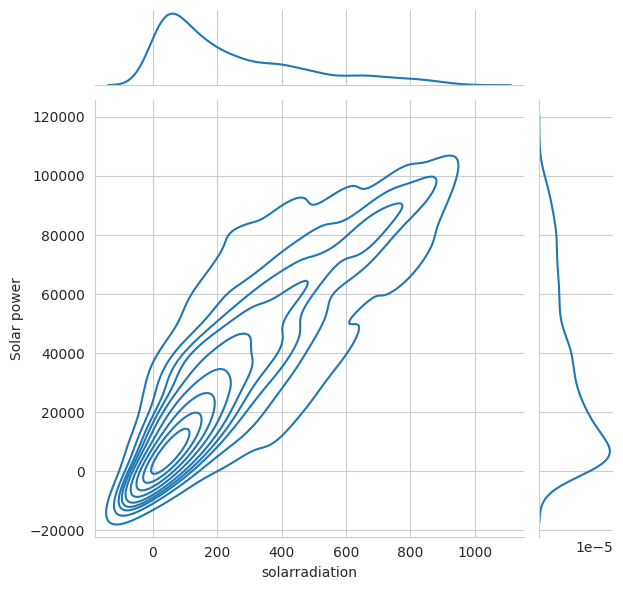

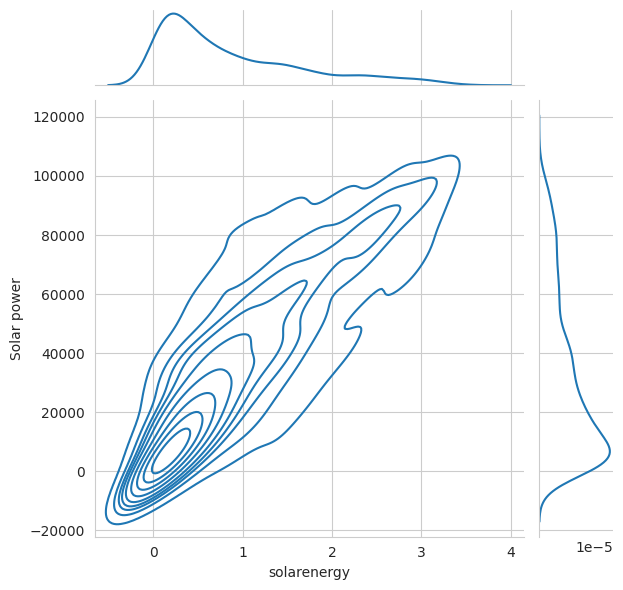

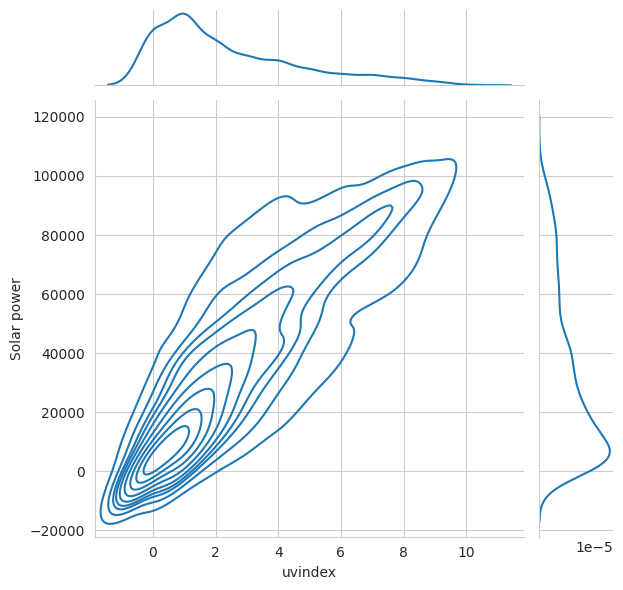

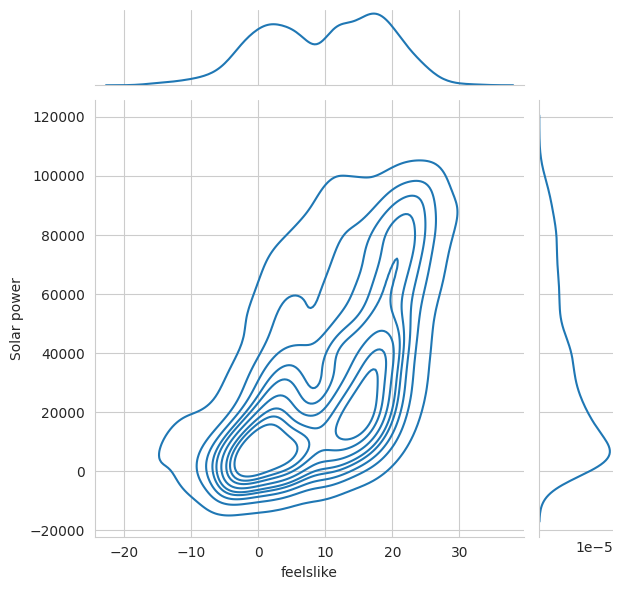

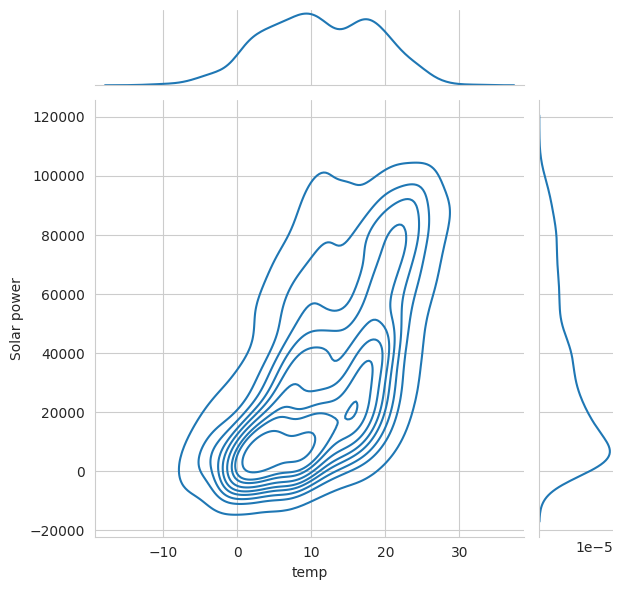

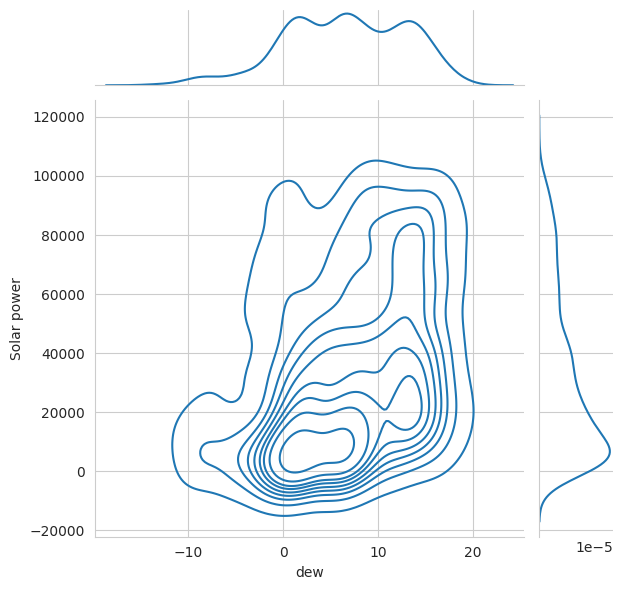

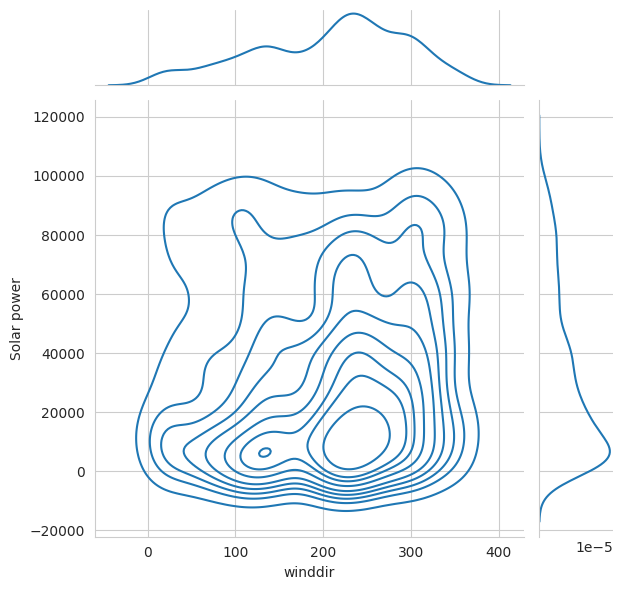

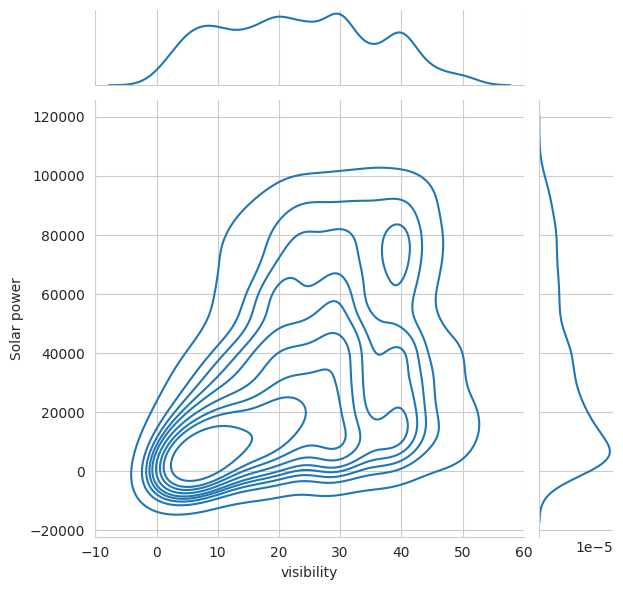

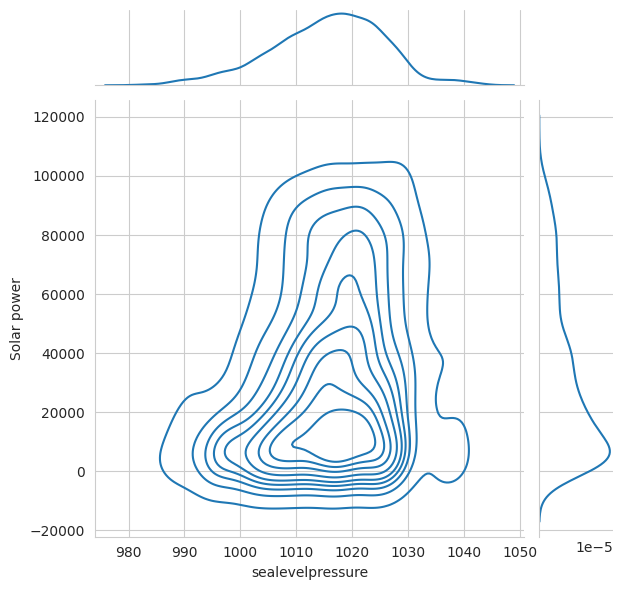

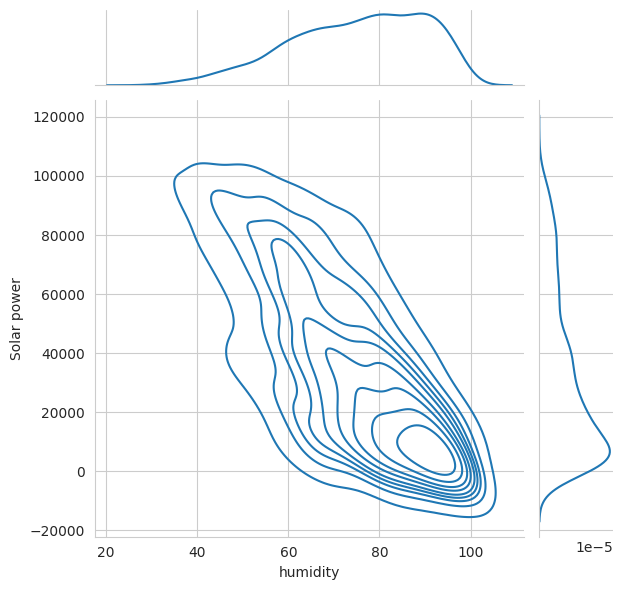

In [74]:
num_cols = ["solarradiation","solarenergy", "uvindex","feelslike","temp", "dew", "winddir","visibility", "sealevelpressure","humidity"]

def plot_desity_2d(df, cols, col_y='Solar power', kind='kde'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.jointplot(x=col, y=col_y, data=df, kind=kind)
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel(col_y)# Set text for y axis
        plt.show()

plot_desity_2d(df_weather_actual, num_cols)

### Correlation coefficients of all features

The correlation matrix shows some multicollinearity between variables, as well as many weak correlations.

<ipython-input-75-8cd334a38a5e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_weather_actual.corr(), cmap='Greens', annot=True)


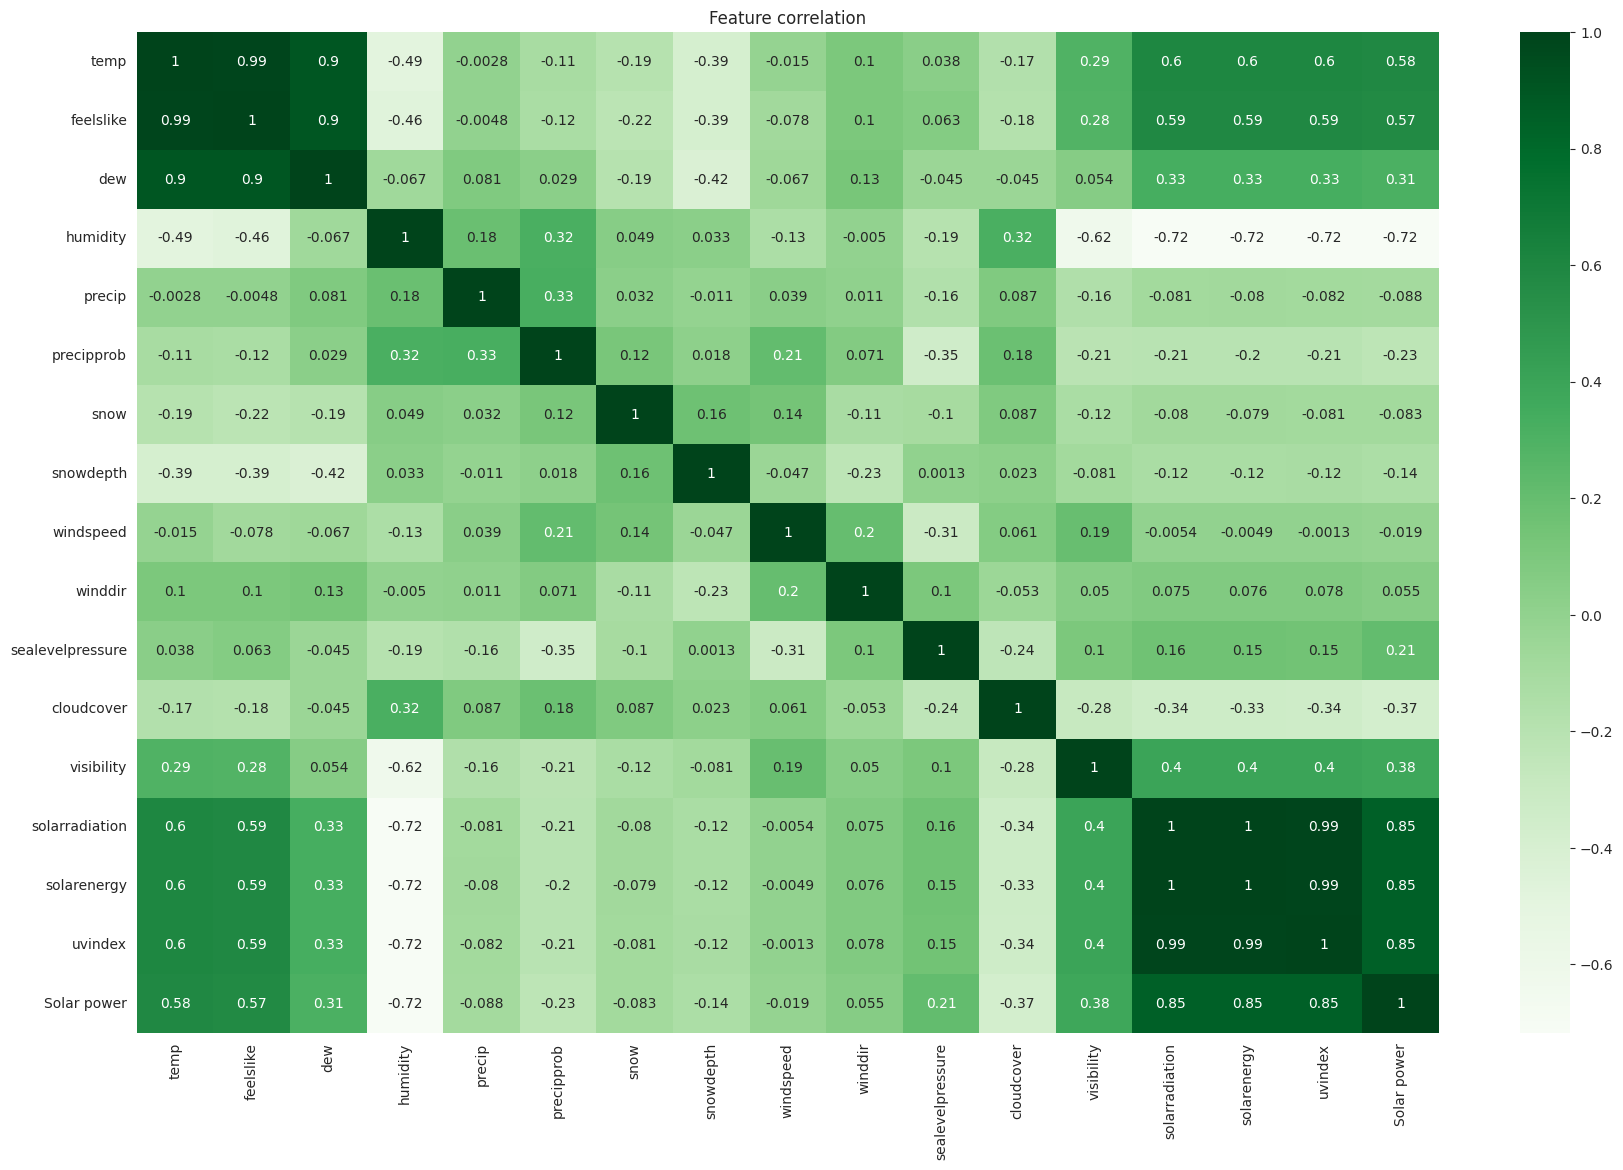

In [75]:
# Feature correlation for all features
plt.figure(figsize=(21, 13))
sns.heatmap(df_weather_actual.corr(), cmap='Greens', annot=True)
plt.title('Feature correlation');

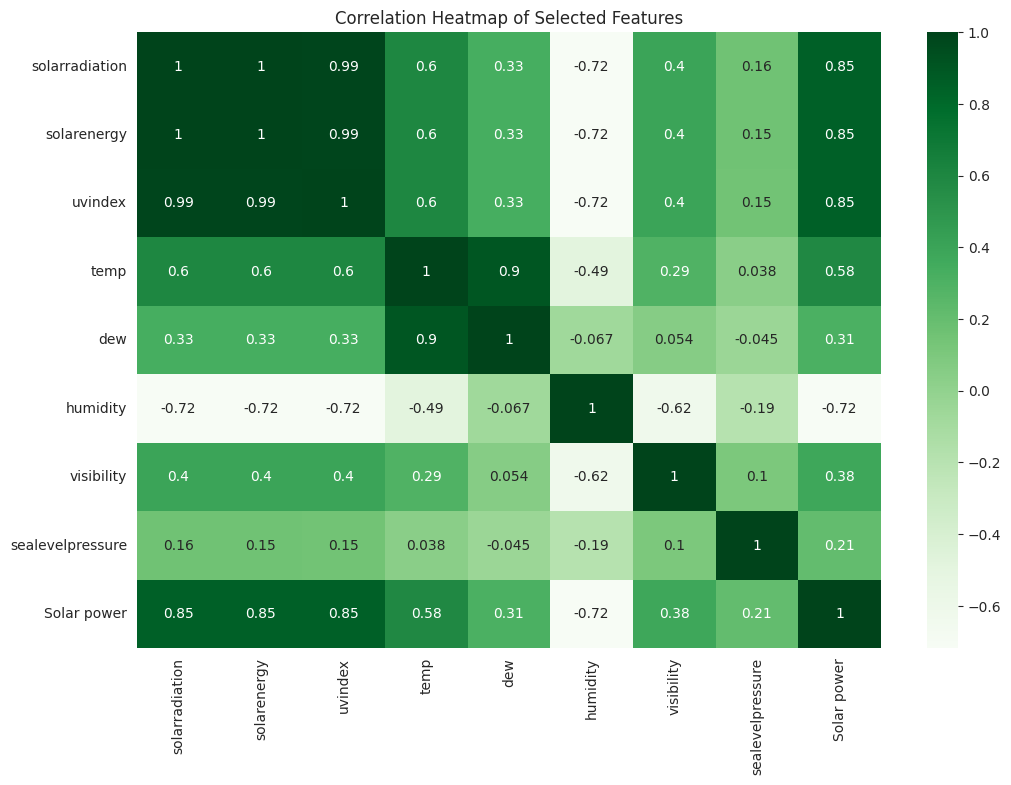

In [76]:
import seaborn as sns

# Select the columns for correlation
selected_columns = ["solarradiation", "solarenergy", "uvindex", "temp", "dew", "humidity", "visibility", "sealevelpressure", "Solar power"]

# Subset the DataFrame with selected columns
df_selected = df_weather_actual[selected_columns]

# Feature correlation for selected features
plt.figure(figsize=(12, 8))
sns.heatmap(df_selected.corr(), cmap='Greens', annot=True)
plt.title('Correlation Heatmap of Selected Features')
plt.show()


## Applying Linear Regression

In [77]:
print(df_weather_actual['icon'].value_counts())

partly-cloudy-day    719
clear-day            607
rain                 597
cloudy               560
snow                  62
fog                    2
wind                   1
Name: icon, dtype: int64


we are going to select only `icon` as categorical feature

In [78]:
print(df_weather_actual['icon'].unique())
Features = df_weather_actual['icon']
enc = preprocessing.LabelEncoder()
enc.fit(Features)
Features = enc.transform(Features)
print(Features)


['partly-cloudy-day' 'rain' 'cloudy' 'snow' 'clear-day' 'wind' 'fog']
[3 4 3 ... 4 4 4]


In [79]:

ohe = preprocessing.OneHotEncoder()
encoded = ohe.fit(Features.reshape(-1,1))
print(Features.reshape(-1,1))
Features = encoded.transform(Features.reshape(-1,1)).toarray()
Features.shape


[[3]
 [4]
 [3]
 ...
 [4]
 [4]
 [4]]


(2548, 7)

In [80]:

def encode_string(cat_feature):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_feature)
    enc_cat_feature = enc.transform(cat_feature)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_feature.reshape(-1,1))
    return encoded.transform(enc_cat_feature.reshape(-1,1)).toarray()



categorical_columns = ['conditions']

for col in categorical_columns:
    temp = encode_string(df_weather_actual[col])
    #Features = encode_string(df_weather_actual[col])
    Features = np.concatenate([Features, temp], axis = 1)
    print(Features)

print(Features.shape)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(2548, 18)


In [81]:
Features = np.concatenate([Features, np.array(df_weather_actual[["solarradiation","solarenergy","uvindex", "temp", "dew", "humidity", "visibility", "sealevelpressure"]])], axis = 1)
print(Features.shape)
Features[:2,:]

(2548, 26)


array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  3.0000e+00,  0.0000e+00,
         0.0000e+00,  7.0000e-01, -1.0000e-01,  9.4450e+01,  7.0000e+00,
         1.0061e+03],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  1.4000e+01,  1.0000e-01,
         0.0000e+00,  1.6000e+00,  7.0000e-01,  9.3780e+01,  6.0000e+00,
         1.0065e+03]])

In [82]:
print(Features.shape)

(2548, 26)


## Split the dataset and standard scaler

In [83]:

# Set a seed for reproducibility
np.random.seed(123)


nr.seed(123)
labels = np.array(df_weather_actual['Solar power'])
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size=0.25)

x_train = Features[indx[0], :]
y_train = np.ravel(labels[indx[0]])

x_test = Features[indx[1], :]
y_test = np.ravel(labels[indx[1]])

scaler = preprocessing.StandardScaler().fit(x_train[:,18:])
x_train[:,18:] = scaler.transform(x_train[:,18:])
x_test[:,18:] = scaler.transform(x_test[:,18:])

y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

scaler_y = preprocessing.StandardScaler().fit(y_train)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)




In [84]:
print(x_train.shape)

(1911, 26)


## Rescale Numeric features

In [85]:
print(df_weather_actual.isnull().sum())


datetime            0
name                0
temp                0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
snow                0
snowdepth           0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
conditions          0
icon                0
Solar power         0
dtype: int64


In [86]:
## define and fit the linear regression model
lin_mod = linear_model.LinearRegression(fit_intercept = False)
lin_mod.fit(x_train, y_train_scaled)


LinearRegression(fit_intercept=False)

## Intially empty your model folder

In [87]:
for x in os.listdir('./models'):
    os.remove('./models/'+x)

In [88]:
#from sklearn.externals import joblib

filename = str(int(time.time())) + '_model_' + 'linear_mod.pkl'
# Save the model as a pickle in a file
joblib.dump(lin_mod, './models/'+filename)

['./models/1696255015_model_linear_mod.pkl']

In [89]:
# Define the print_metrics function
def print_metrics(y_true, y_predicted, n_parameters):
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)

    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))

    return sklm.mean_squared_error(y_true, y_predicted), r2


y_score = lin_mod.predict(x_test)

# Inverse transform the scaled y_test to get original values
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).squeeze()

# Assuming y_predicted_scaled contains the predicted values in scaled form
y_predicted_original = scaler_y.inverse_transform(y_score.reshape(-1, 1)).squeeze()

# Calculate and print metrics
(rmse, r2) = print_metrics(y_test_scaled, y_score, 28)


Mean Square Error      = 0.23213936972170546
Root Mean Square Error = 0.48180843674815976
Mean Absolute Error    = 0.34712071014934837
Median Absolute Error  = 0.25288992153672085
R^2                    = 0.7648398704863757
Adjusted R^2           = 0.7544140519365106


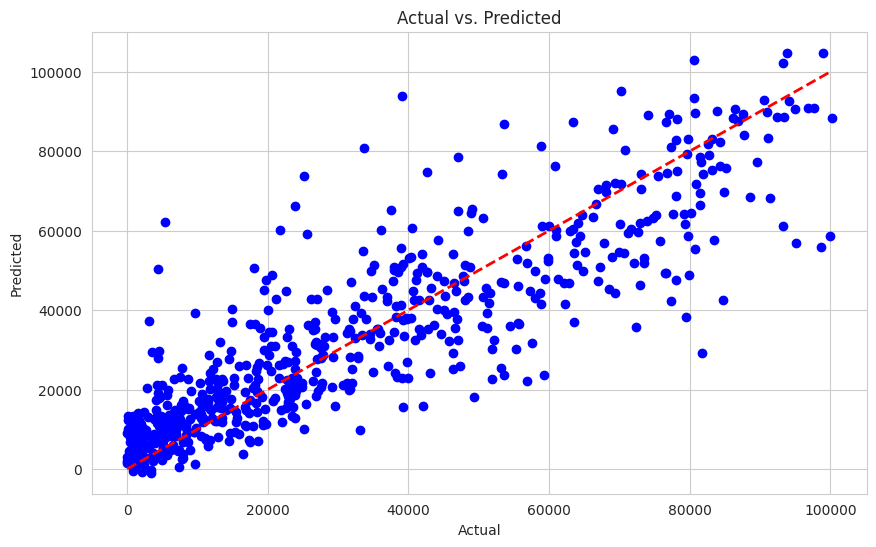

In [90]:
# Inverse transform the scaled y_test to get original values
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).squeeze()

# Assuming y_predicted_scaled contains the predicted values in scaled form
y_predicted_original = scaler_y.inverse_transform(y_score.reshape(-1, 1)).squeeze()

# Plot the original y_test and y_predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_predicted_original, color='blue')
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()


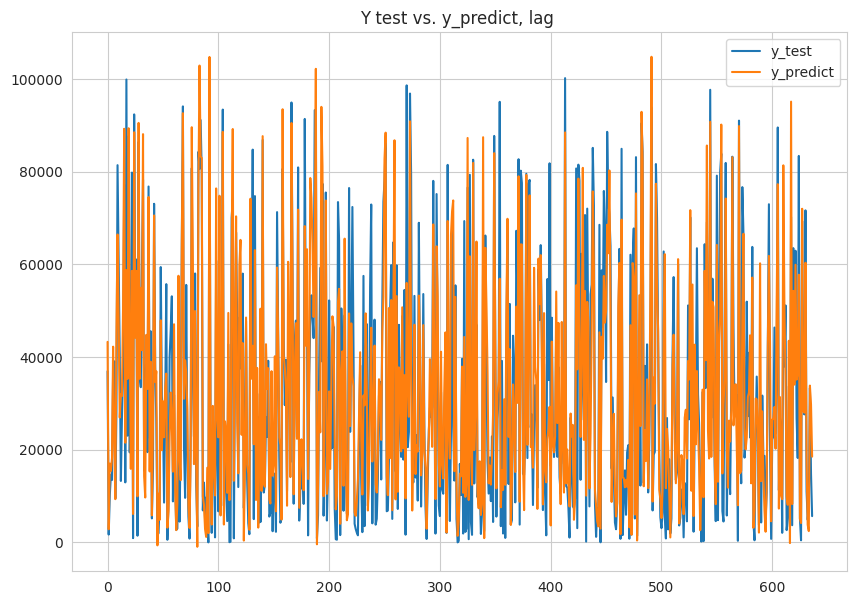

In [91]:
def plot_res(y_test, y_score, label_test, label_score, dpi=100):
    plt.figure(figsize=(10,7), dpi=dpi)
    plt.plot(y_test, label=label_test)
    plt.plot(y_score, label=label_score)
    plt.legend(loc=1)
    plt.title('Y test vs. y_predict, lag ' )
    plt.show()

plot_res(y_test_original, y_predicted_original, label_test = 'y_test', label_score='y_predict')

In [92]:
model_results = []

In [93]:
# Save all the results

model_results_dict = {}

model_results_dict['Algo'] = 'Linear Regression'
model_results_dict['lag'] = 'NA'
model_results_dict['dropout'] = 'NA'
model_results_dict['epochs'] = 'NA'
model_results_dict['batch_size'] = 'NA'
model_results_dict['loss'] = 'NA'
model_results_dict['rmse'] = rmse
model_results_dict['power_gen_rmse'] = math.sqrt(rmse)
model_results_dict['r2'] = r2
model_results_dict['model_filename'] = filename
model_results_dict['time_ran'] = int(time.time())
model_results.append(model_results_dict)


In [94]:
new_res_df = pd.DataFrame(model_results)
new_res_df.to_csv('./result/result.csv')

## Applying LSTM

In [95]:
x_train.shape

(1911, 26)

The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

1. Samples. One sequence is one sample. A batch is comprised of one or more samples.
2. Time Steps. One time step is one point of observation in the sample.
3. Features. One feature is one observation at a time step.

In [96]:
X_train = x_train
X_test = x_test



# Print the shapes of the scaled data to verify
print('x_train_scaled shape:', X_train.shape)
print('x_test_scaled shape:', X_test.shape)

x_train_scaled shape: (1911, 26)
x_test_scaled shape: (637, 26)


In [97]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape)
print(X_test.shape)

(1911, 1, 26)
(637, 1, 26)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24)                4896      
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 4921 (19.22 KB)
Trainable params: 4921 (19.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
60/60 [==============================] - 4s 14ms/step - loss: 0.7863 - val_loss: 0.4509
Epoch 2/60
60/60 [==============================] - 0s 4ms/step - loss: 0.3532 - val_loss: 0.2521
Epoch 3/60
60/60 [==============================] - 0s 3ms/step - loss: 0.2712 - val

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


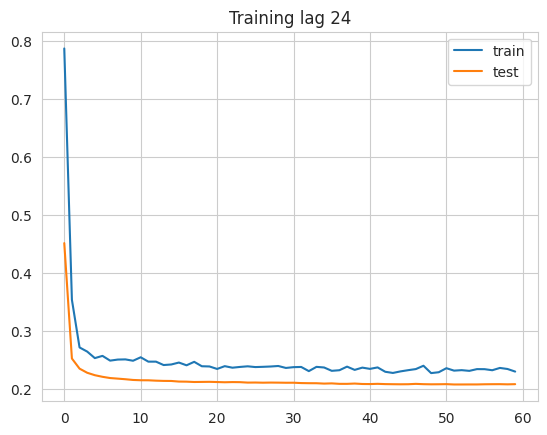

20/20 [==============================] - 0s 2ms/step
Mean Square Error      = 0.2078812800753151
Root Mean Square Error = 0.4559399961347053
Mean Absolute Error    = 0.32402539507287303
Median Absolute Error  = 0.2196441985069445
R^2                    = 0.789413623356632
Adjusted R^2           = 0.7800772815350049


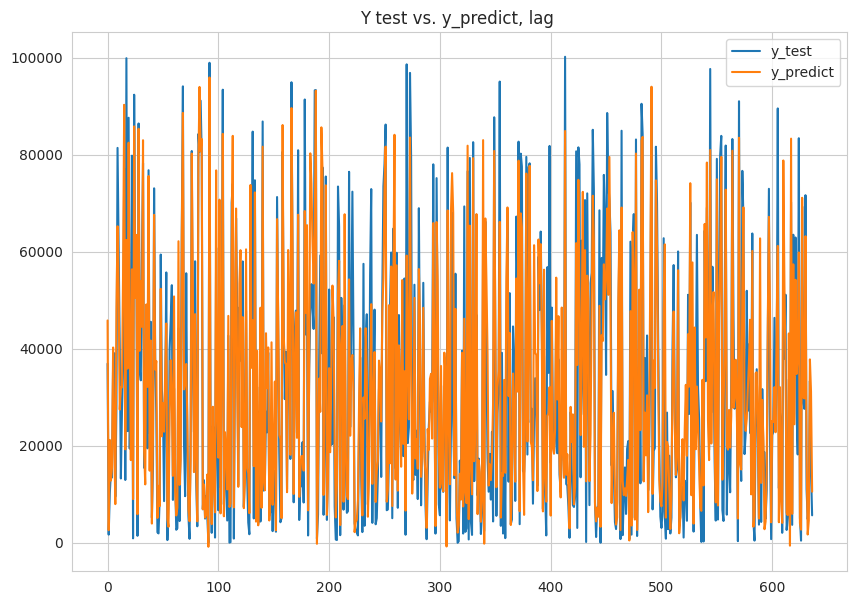

In [98]:

def LSTM_model(X_train, y_train, X_test, y_test,batch_size_= 32, dropout_=.25,epochs_=60, samples=24):


    # comment out this box and uncomment load_model to load saved model
    #################################################################################
                                                                                    #
    # design network                                                                #
    model = Sequential()                                                            #
    model.add(LSTM(int(samples), input_shape=(X_train.shape[1], X_train.shape[2]))) #
    model.add(Dropout(dropout_))                                                    #
    model.add(Dense(1))                                                             #
    model.compile(loss='mean_squared_error', optimizer='adam')                      #
    print(model.summary())                                                                                #
    # fit network                                                                   #
    history = model.fit(X_train,                                                    #
                        y_train,                                                    #
                        epochs=epochs_,                                             #
                        batch_size=batch_size_,                                     #
                        validation_data=(X_test, y_test),                           #
                        verbose=1,                                                  #
                        shuffle=False)                                              #
                                                                                    #
    # Save model for later                                                          #
    filename = str(int(time.time())) + '_model_' + str(samples) + '_lag.h5'         #
    model.save('./models/' + filename)                                              #
                                                                                    #
    #################################################################################



    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('Training lag ' + str(samples))
    plt.show()

    y_score = model.predict(X_test)

    (rmse, r2) = print_metrics(y_test, y_score, 28)

    y_score = scaler_y.inverse_transform(y_score.reshape(-1, 1)).squeeze() # unscale the predictions
    y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).squeeze() # unscale the true test outcomes


    plot_res(y_test, y_score, label_test = 'y_test', label_score='y_predict')

    # Save all the results

    model_results_dict = {}

    model_results_dict['Algo'] = 'LSTM'
    model_results_dict['lag'] = samples
    model_results_dict['dropout'] = dropout_
    model_results_dict['epochs'] = epochs_
    model_results_dict['batch_size'] = batch_size_
    model_results_dict['loss'] = history.history
    model_results_dict['rmse'] = rmse
    model_results_dict['power_gen_rmse'] = math.sqrt(rmse)
    model_results_dict['r2'] = r2
    model_results_dict['model_filename'] = filename
    model_results_dict['time_ran'] = int(time.time())
    model_results.append(model_results_dict)


LSTM_model(X_train,y_train_scaled, X_test,y_test_scaled)

## Test LSTM model for different parameters

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24)                4896      
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 4921 (19.22 KB)
Trainable params: 4921 (19.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
30/30 [==============================] - 3s 20ms/step - loss: 0.8729 - val_loss: 0.6598
Epoch 2/60
30/30 [==============================] - 0s 4ms/step - loss: 0.5531 - val_loss: 0.4039
Epoch 3/60
30/30 [==============================] - 0s 4ms/step - loss: 0.3772 - v

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


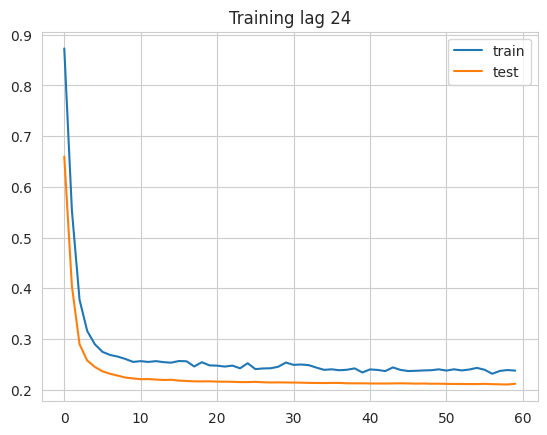

20/20 [==============================] - 0s 2ms/step
Mean Square Error      = 0.21149723380679106
Root Mean Square Error = 0.459888284050367
Mean Absolute Error    = 0.32701222812202485
Median Absolute Error  = 0.2252254640266831
R^2                    = 0.7857506163069077
Adjusted R^2           = 0.7762518751579528


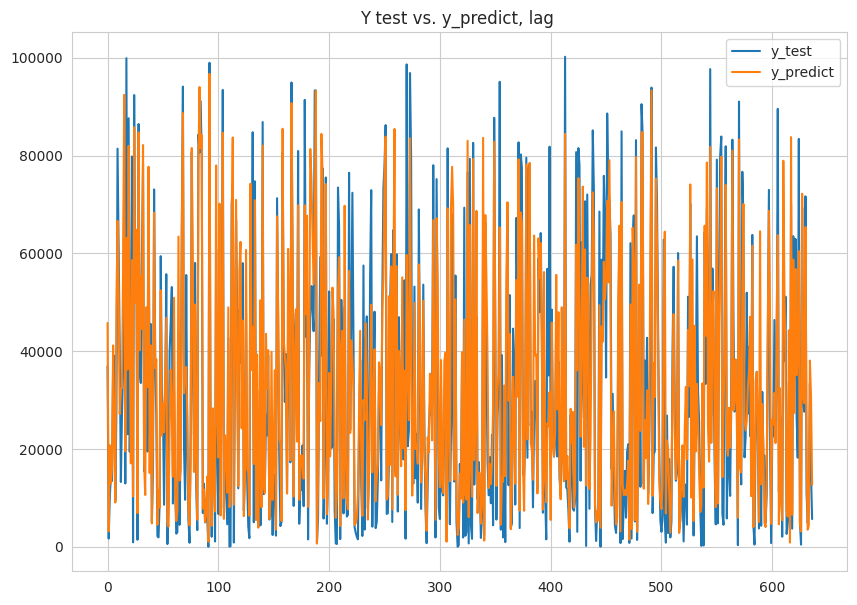

In [99]:
batch_size_ = 64
dropout_ =0.3
epochs_ = 60
samples = 24

LSTM_model(X_train,y_train_scaled, X_test,y_test_scaled, batch_size_, dropout_, epochs_, samples)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 24)             4896      
                                                                 
 dropout_2 (Dropout)         (None, 1, 24)             0         
                                                                 
 lstm_3 (LSTM)               (None, 24)                4704      
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                800       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10433 (40.75 KB)
Trainable params: 10433

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


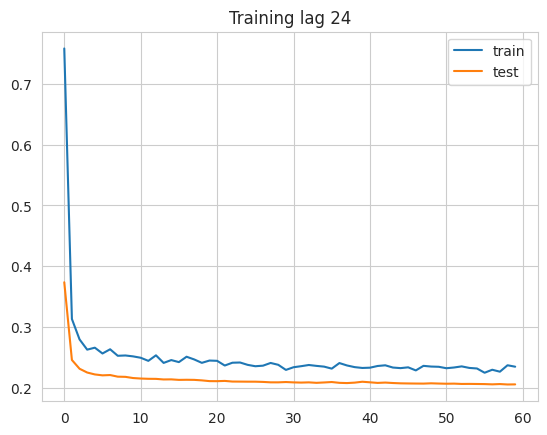

20/20 [==============================] - 1s 2ms/step
Mean Square Error      = 0.20535644048532606
Root Mean Square Error = 0.4531627086216672
Mean Absolute Error    = 0.3191989992308939
Median Absolute Error  = 0.2235813934806976
R^2                    = 0.7919713179247475
Adjusted R^2           = 0.7827483714288004


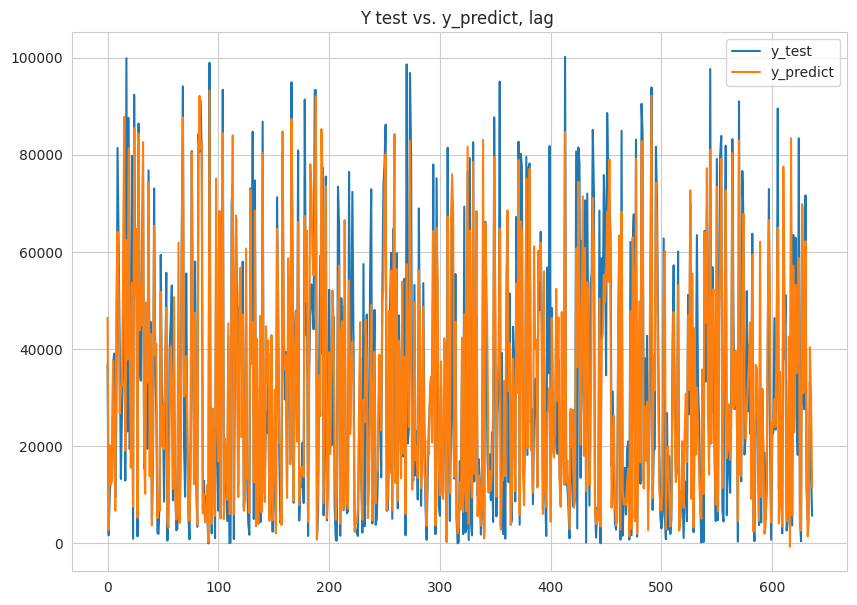

In [100]:
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time
import math

# Assuming your data is loaded and preprocessed

def Enhanced_LSTM_model(X_train, y_train, X_test, y_test, batch_size_=32, dropout_=0.25, epochs_=60, samples=24):

    # Initialize the model
    model = Sequential()

    # Add the first LSTM layer
    model.add(LSTM(units=samples, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout_))

    # Add a second LSTM layer
    model.add(LSTM(units=samples, return_sequences=False))
    model.add(Dropout(dropout_))

    # Add a Dense layer
    model.add(Dense(32, activation='relu'))

    # Add the output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())

    # Fit the model
    history = model.fit(X_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(X_test, y_test), verbose=1, shuffle=False)

    # Save the model
    filename = str(int(time.time())) + '_enhanced_model_' + str(samples) + '_lag.h5'
    model.save('./models/' + filename)

    # Plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('Training lag ' + str(samples))
    plt.show()

    # Predictions
    y_score = model.predict(X_test)

    # Assuming you have functions defined like print_metrics and plot_res
    (rmse, r2) = print_metrics(y_test, y_score, 28)
    y_score = scaler_y.inverse_transform(y_score.reshape(-1, 1)).squeeze() # unscale the predictions
    y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).squeeze() # unscale the true test outcomes
    plot_res(y_test, y_score, label_test='y_test', label_score='y_predict')

    # Save all the results
    model_results_dict = {}
    model_results_dict['Algo'] = 'LSTM'
    model_results_dict['lag'] = samples
    model_results_dict['dropout'] = dropout_
    model_results_dict['epochs'] = epochs_
    model_results_dict['batch_size'] = batch_size_
    model_results_dict['loss'] = history.history
    model_results_dict['rmse'] = rmse
    model_results_dict['power_gen_rmse'] = math.sqrt(rmse)
    model_results_dict['r2'] = r2
    model_results_dict['model_filename'] = filename
    model_results_dict['time_ran'] = int(time.time())
    model_results.append(model_results_dict)

# Call the function
Enhanced_LSTM_model(X_train, y_train_scaled, X_test, y_test_scaled)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 24)             4896      
                                                                 
 dropout_4 (Dropout)         (None, 1, 24)             0         
                                                                 
 lstm_5 (LSTM)               (None, 1, 24)             4704      
                                                                 
 dropout_5 (Dropout)         (None, 1, 24)             0         
                                                                 
 lstm_6 (LSTM)               (None, 24)                4704      
                                                                 
 dropout_6 (Dropout)         (None, 24)                0         
                                                                 
 dense_4 (Dense)             (None, 32)               

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


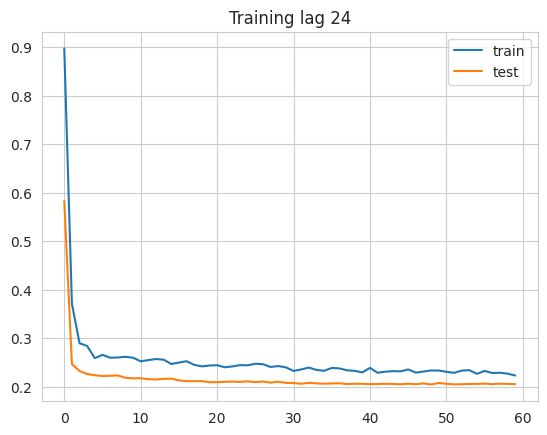

20/20 [==============================] - 2s 3ms/step
Mean Square Error      = 0.20527959767559145
Root Mean Square Error = 0.4530779156785193
Mean Absolute Error    = 0.3193283842179805
Median Absolute Error  = 0.21536109226705902
R^2                    = 0.7920491606668513
Adjusted R^2           = 0.782829665326958


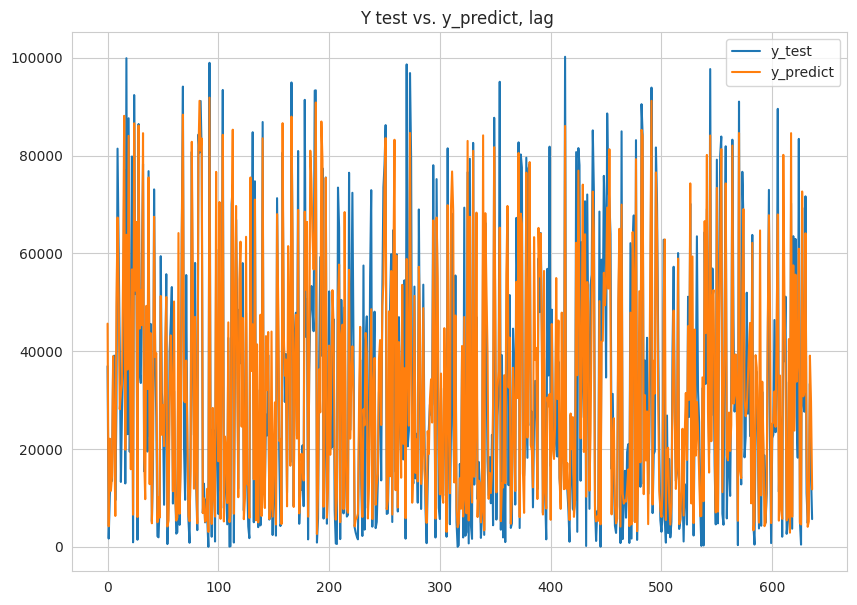

In [101]:
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time
import math

# Assuming your data is loaded and preprocessed

def Enhanced2_LSTM_model(X_train, y_train, X_test, y_test, batch_size_=32, dropout_=0.25, epochs_=60, samples=24):
  # Initialize the model
  model = Sequential()

  # Add the first LSTM layer
  model.add(LSTM(units=samples, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model.add(Dropout(dropout_))

  # Add a second LSTM layer
  model.add(LSTM(units=samples, return_sequences=True))
  model.add(Dropout(dropout_))

  # Add a third LSTM layer
  model.add(LSTM(units=samples, return_sequences=False))
  model.add(Dropout(dropout_))

  # Add a Dense layer
  model.add(Dense(32, activation='relu'))

  # Add another Dense layer
  model.add(Dense(16, activation='relu'))

  # Add the output layer
  model.add(Dense(1))

  # Compile the model
  optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  print(model.summary())
  # Fit the model
  history = model.fit(X_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(X_test, y_test), verbose=1, shuffle=False)

  # Save the model
  filename = str(int(time.time())) + '_enhanced_model_' + str(samples) + '_lag.h5'
  model.save('./models/' + filename)

  # Plot history
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.title('Training lag ' + str(samples))
  plt.show()

  # Predictions
  y_score = model.predict(X_test)

  # Assuming you have functions defined like print_metrics and plot_res
  (rmse, r2) = print_metrics(y_test, y_score, 28)
  y_score = scaler_y.inverse_transform(y_score.reshape(-1, 1)).squeeze() # unscale the predictions
  y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).squeeze() # unscale the true test outcomes
  plot_res(y_test, y_score, label_test='y_test', label_score='y_predict')

  # Save all the results
  model_results_dict = {}
  model_results_dict['Algo'] = 'LSTM'
  model_results_dict['lag'] = samples
  model_results_dict['dropout'] = dropout_
  model_results_dict['epochs'] = epochs_
  model_results_dict['batch_size'] = batch_size_
  model_results_dict['loss'] = history.history
  model_results_dict['rmse'] = rmse
  model_results_dict['power_gen_rmse'] = math.sqrt(rmse)
  model_results_dict['r2'] = r2
  model_results_dict['model_filename'] = filename
  model_results_dict['time_ran'] = int(time.time())
  model_results.append(model_results_dict)

# Call the function
Enhanced2_LSTM_model(X_train, y_train_scaled, X_test, y_test_scaled)

In [102]:
model_results

[{'Algo': 'Linear Regression',
  'lag': 'NA',
  'dropout': 'NA',
  'epochs': 'NA',
  'batch_size': 'NA',
  'loss': 'NA',
  'rmse': 0.23213936972170546,
  'power_gen_rmse': 0.48180843674815976,
  'r2': 0.7648398704863757,
  'model_filename': '1696255015_model_linear_mod.pkl',
  'time_ran': 1696255016},
 {'Algo': 'LSTM',
  'lag': 24,
  'dropout': 0.25,
  'epochs': 60,
  'batch_size': 32,
  'loss': {'loss': [0.786285936832428,
    0.35322442650794983,
    0.27117154002189636,
    0.26401954889297485,
    0.2527768611907959,
    0.25661981105804443,
    0.24843525886535645,
    0.2502633333206177,
    0.25055983662605286,
    0.24822930991649628,
    0.25420495867729187,
    0.24668201804161072,
    0.2466859072446823,
    0.24082744121551514,
    0.24179479479789734,
    0.24511389434337616,
    0.24038289487361908,
    0.24636797606945038,
    0.23875732719898224,
    0.23839253187179565,
    0.23410966992378235,
    0.2389131635427475,
    0.23626644909381866,
    0.2375800907611847,
  

In [103]:
new_res_df = pd.DataFrame(model_results)
# old_res_df = pd.read_csv('./result/result.csv', index_col=0)
# res_df = pd.concat([old_res_df, new_res_df], axis=0, sort=False).reset_index(drop=True)
new_res_df.to_csv('./result/result.csv')

In [104]:
models_by_r2 = new_res_df.sort_values(by='r2', ascending=False)
models_by_r2.head()

Algo lag dropout epochs batch_size  \
4               LSTM  24    0.25     60         32   
3               LSTM  24    0.25     60         32   
1               LSTM  24    0.25     60         32   
2               LSTM  24     0.3     60         64   
0  Linear Regression  NA      NA     NA         NA   

                                                loss      rmse  \
4  {'loss': [0.8970687985420227, 0.37086847424507...  0.205280   
3  {'loss': [0.7584456205368042, 0.31299927830696...  0.205356   
1  {'loss': [0.786285936832428, 0.353224426507949...  0.207881   
2  {'loss': [0.8729152679443359, 0.55309462547302...  0.211497   
0                                                 NA  0.232139   

   power_gen_rmse        r2                       model_filename    time_ran  
4        0.453078  0.792049  1696255116_enhanced_model_24_lag.h5  1696255119  
3        0.453163  0.791971  1696255078_enhanced_model_24_lag.h5  1696255079  
1        0.455940  0.789414           1696255035_model_24_lag.h5  1696255036  
2        0.459888  0.785751           1696255049_model_24_lag.h5  1696255050  
0        0.481808  0.764840      1696255015_model_linear_mod.pkl  1696255016

In [105]:
model_filename = models_by_r2['model_filename'].iloc[0]
if(model_filename.endswith('.pkl')):
    model = joblib.load('./models/'+ model_filename)
else:
    model = load_model('./models/'+ model_filename)



## Predicting weather forecast data

In [106]:
df_forecast = pd.read_csv('weather_forecast.csv')
df_forecast.head()
print(df_forecast.shape)


(210, 21)


In [107]:
df_forecast.isna().sum()

datetime            0
name                0
temp                0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
snow                0
snowdepth           0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
conditions          0
icon                0
Solar power         0
dtype: int64

In [108]:

df_forecast.shape

(210, 21)

In [109]:
df_weather_actual.head()

datetime    name  temp  feelslike  dew  humidity  precip  \
0 2021-01-01 09:00:00  bremen   0.7        0.7 -0.1     94.45   0.000   
1 2021-01-01 10:00:00  bremen   1.6        1.6  0.7     93.78   0.001   
2 2021-01-01 11:00:00  bremen   2.5       -0.9  1.3     91.84   0.000   
3 2021-01-01 12:00:00  bremen   3.1        0.7  1.7     90.49   0.000   
4 2021-01-01 13:00:00  bremen   4.0        1.0  1.9     85.83   0.000   

   precipprob  snow  snowdepth  windspeed  winddir  sealevelpressure  \
0           0   0.0        0.0        3.6    220.0            1006.1   
1         100   0.0        0.0        4.7    210.0            1006.5   
2           0   0.0        0.0       12.9    230.0            1006.8   
3           0   0.0        0.0        8.7    240.0            1007.0   
4           0   0.0        0.0       12.2    220.0            1006.9   

   cloudcover  visibility  solarradiation  solarenergy  uvindex  \
0        59.8         7.0             3.0          0.0        0   
1        43.9         6.0            14.0          0.1        0   
2        42.1         8.0            69.0          0.2        1   
3        40.9        10.0            84.0          0.3        1   
4        45.3        12.0           100.0          0.4        1   

                     conditions               icon  Solar power  
0              Partially cloudy  partly-cloudy-day        708.0  
1  Snow, Rain, Partially cloudy               rain       5416.5  
2              Partially cloudy  partly-cloudy-day       8661.0  
3              Partially cloudy  partly-cloudy-day      11729.2  
4              Partially cloudy  partly-cloudy-day       9282.2

In [110]:
df_weather_actual.shape

(2548, 21)

In [111]:
df_weather_actual_total = pd.concat([df_weather_actual, df_forecast], axis=0, sort=False).reset_index(drop=True)

In [112]:
df_weather_actual_total.tail()

datetime    name  temp  feelslike  dew  humidity  precip  \
2753  2022-01-30 11:00:00  bremen   7.8        3.7  6.7     92.31   0.516   
2754  2022-01-30 12:00:00  bremen   8.0        3.6  6.6     90.50   2.016   
2755  2022-01-30 13:00:00  bremen   8.0        3.5  6.4     89.32   3.025   
2756  2022-01-30 14:00:00  bremen   2.5       -2.6  1.5     93.09   4.705   
2757  2022-01-30 15:00:00  bremen   3.9        0.6  2.9     93.19   1.414   

      precipprob  snow  snowdepth  windspeed  winddir  sealevelpressure  \
2753         100   0.0        0.0       31.2    220.0             996.7   
2754         100   0.0        0.0       36.3    220.0             994.9   
2755         100   0.0        0.0       38.0    230.0             992.8   
2756         100   0.0        0.0       24.1    290.0             993.8   
2757         100   0.0        0.0       14.0    240.0             993.3   

      cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2753       100.0         8.0            28.0          0.1        0   
2754       100.0        10.0            20.0          0.1        0   
2755       100.0         8.0            17.0          0.1        0   
2756       100.0         7.0            23.0          0.1        0   
2757       100.0        24.9            36.0          0.1        0   

          conditions  icon  Solar power  
2753  Rain, Overcast  rain       2285.8  
2754  Rain, Overcast  rain       1972.2  
2755  Rain, Overcast  rain       1216.5  
2756  Rain, Overcast  rain       2880.5  
2757  Rain, Overcast  rain       1732.5

In [113]:
df_weather_actual_total.to_csv('weather_actual_total.csv')

In [114]:
df_weather_actual_total = pd.read_csv('weather_actual_total.csv')
df_weather_actual_total = df_weather_actual_total.drop(['Solar power'], axis=1)
df_weather_actual_total.tail()

Unnamed: 0             datetime    name  temp  feelslike  dew  humidity  \
2753        2753  2022-01-30 11:00:00  bremen   7.8        3.7  6.7     92.31   
2754        2754  2022-01-30 12:00:00  bremen   8.0        3.6  6.6     90.50   
2755        2755  2022-01-30 13:00:00  bremen   8.0        3.5  6.4     89.32   
2756        2756  2022-01-30 14:00:00  bremen   2.5       -2.6  1.5     93.09   
2757        2757  2022-01-30 15:00:00  bremen   3.9        0.6  2.9     93.19   

      precip  precipprob  snow  snowdepth  windspeed  winddir  \
2753   0.516         100   0.0        0.0       31.2    220.0   
2754   2.016         100   0.0        0.0       36.3    220.0   
2755   3.025         100   0.0        0.0       38.0    230.0   
2756   4.705         100   0.0        0.0       24.1    290.0   
2757   1.414         100   0.0        0.0       14.0    240.0   

      sealevelpressure  cloudcover  visibility  solarradiation  solarenergy  \
2753             996.7       100.0         8.0            28.0          0.1   
2754             994.9       100.0        10.0            20.0          0.1   
2755             992.8       100.0         8.0            17.0          0.1   
2756             993.8       100.0         7.0            23.0          0.1   
2757             993.3       100.0        24.9            36.0          0.1   

      uvindex      conditions  icon  
2753        0  Rain, Overcast  rain  
2754        0  Rain, Overcast  rain  
2755        0  Rain, Overcast  rain  
2756        0  Rain, Overcast  rain  
2757        0  Rain, Overcast  rain

In [115]:
print(df_weather_actual_total['icon'].unique())
Features_forecast_total = df_weather_actual_total['icon']
enc = preprocessing.LabelEncoder()
enc.fit(Features_forecast_total)
Features_forecast_total = enc.transform(Features_forecast_total)


['partly-cloudy-day' 'rain' 'cloudy' 'snow' 'clear-day' 'wind' 'fog']


In [116]:
ohe = preprocessing.OneHotEncoder()
encoded = ohe.fit(Features_forecast_total.reshape(-1,1))

Features_forecast_total = encoded.transform(Features_forecast_total.reshape(-1,1)).toarray()


In [117]:
def encode_string(cat_feature):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_feature)
    enc_cat_feature = enc.transform(cat_feature)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_feature.reshape(-1,1))
    return encoded.transform(enc_cat_feature.reshape(-1,1)).toarray()


categorical_columns = ['conditions']

for col in categorical_columns:
    temp = encode_string(df_weather_actual_total[col])
    Features_forecast_total = np.concatenate([Features_forecast_total, temp], axis = 1)
    #print(Features)

print(Features_forecast_total.shape)


(2758, 18)


In [118]:
Features_forecast_total = np.concatenate([Features_forecast_total, np.array(df_weather_actual_total[["solarradiation","solarenergy", "uvindex", "temp", "dew", "winddir", "visibility", "sealevelpressure"]])], axis = 1)
Features_forecast_total[:2,:]

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  3.0000e+00,  0.0000e+00,
         0.0000e+00,  7.0000e-01, -1.0000e-01,  2.2000e+02,  7.0000e+00,
         1.0061e+03],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  1.4000e+01,  1.0000e-01,
         0.0000e+00,  1.6000e+00,  7.0000e-01,  2.1000e+02,  6.0000e+00,
         1.0065e+03]])

In [119]:
Features_forecast_total.shape

(2758, 26)

In [120]:
Features_forecast_total.shape

(2758, 26)

In [121]:
scaler = preprocessing.StandardScaler().fit(Features_forecast_total[:,18:])
Features_forecast_total[:,18:] = scaler.transform(Features_forecast_total[:,18:])
Features_forecast_total = Features_forecast_total.reshape((Features_forecast_total.shape[0], 1,Features_forecast_total.shape[1]))


In [122]:
print(Features_forecast_total.shape)


(2758, 1, 26)


In [123]:
if(model_filename.endswith('.h5')):
    # make a prediction

    res = model.predict(Features_forecast_total)

    res = scaler_y.inverse_transform(res.reshape(-1, 1)).squeeze()
    # sets floor for res
    #res = np.where(res < 0, 0, res)

    # Ensure res is a float
    res = res.astype(float)
else:
    # make a prediction
    res = model.predict(Features_forecast_total)
    # print(res)

    # sets floor for res
    res = [x if x > 0 else 0 for x in res]

87/87 [==============================] - 1s 2ms/step


In [124]:
# Concat res to dataframe for later

df_weather_actual_total = pd.concat([df_weather_actual_total, pd.DataFrame(res, columns=['predicted_power'], index=df_weather_actual_total.index)], axis=1)

df_weather_actual_total.head(10)

Unnamed: 0             datetime    name  temp  feelslike  dew  humidity  \
0           0  2021-01-01 09:00:00  bremen   0.7        0.7 -0.1     94.45   
1           1  2021-01-01 10:00:00  bremen   1.6        1.6  0.7     93.78   
2           2  2021-01-01 11:00:00  bremen   2.5       -0.9  1.3     91.84   
3           3  2021-01-01 12:00:00  bremen   3.1        0.7  1.7     90.49   
4           4  2021-01-01 13:00:00  bremen   4.0        1.0  1.9     85.83   
5           5  2021-01-01 14:00:00  bremen   3.8        1.2  1.9     86.96   
6           6  2021-01-01 15:00:00  bremen   4.3        0.6  2.2     85.88   
7           7  2021-01-02 09:00:00  bremen   3.6        1.8  2.6     92.73   
8           8  2021-01-02 10:00:00  bremen   3.6        0.8  2.6     92.73   
9           9  2021-01-02 11:00:00  bremen   3.8        0.9  2.9     93.29   

   precip  precipprob  snow  snowdepth  windspeed  winddir  sealevelpressure  \
0   0.000           0   0.0        0.0        3.6    220.0            1006.1   
1   0.001         100   0.0        0.0        4.7    210.0            1006.5   
2   0.000           0   0.0        0.0       12.9    230.0            1006.8   
3   0.000           0   0.0        0.0        8.7    240.0            1007.0   
4   0.000           0   0.0        0.0       12.2    220.0            1006.9   
5   0.000           0   0.0        0.0       10.4    210.0            1006.7   
6   0.001         100   0.0        0.0       17.2    220.0            1007.0   
7   0.000           0   0.0        0.0        7.2    200.0            1012.5   
8   0.004         100   0.0        0.0       11.2    200.0            1012.9   
9   0.000           0   0.0        0.0       11.9    220.0            1013.4   

   cloudcover  visibility  solarradiation  solarenergy  uvindex  \
0        59.8         7.0             3.0          0.0        0   
1        43.9         6.0            14.0          0.1        0   
2        42.1         8.0            69.0          0.2        1   
3        40.9        10.0            84.0          0.3        1   
4        45.3        12.0           100.0          0.4        1   
5        52.9        12.0           160.0          0.6        2   
6        56.6        10.0            47.0          0.2        0   
7        90.2         7.0             7.0          0.0        0   
8        90.6         6.0            10.0          0.0        0   
9        90.3         7.0            36.0          0.1        0   

                     conditions               icon  predicted_power  
0              Partially cloudy  partly-cloudy-day      5365.875977  
1  Snow, Rain, Partially cloudy               rain      5009.368164  
2              Partially cloudy  partly-cloudy-day     10832.729492  
3              Partially cloudy  partly-cloudy-day     12037.346680  
4              Partially cloudy  partly-cloudy-day     15490.223633  
5              Partially cloudy  partly-cloudy-day     31107.863281  
6        Rain, Partially cloudy               rain      8350.487305  
7                      Overcast             cloudy      5830.772461  
8                Rain, Overcast               rain      5632.995117  
9                      Overcast             cloudy      6301.272461

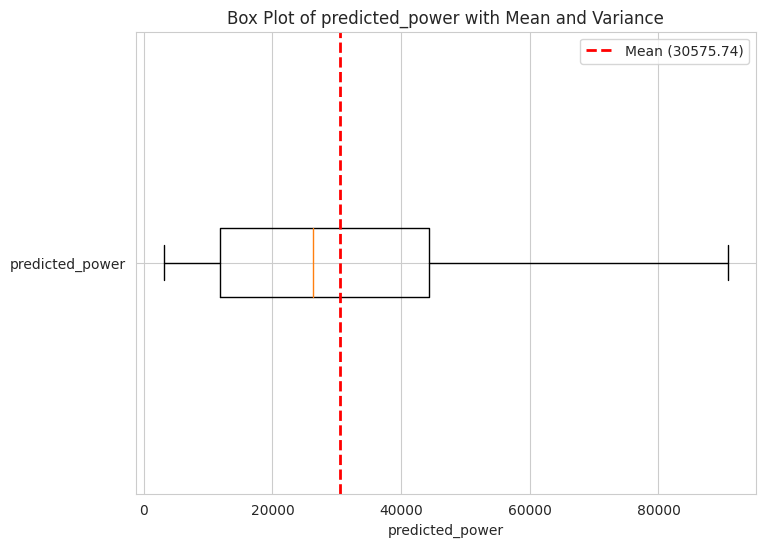

Mean Solar Power: 30575.738673840166
Variance Solar Power: 451824676.89038527


In [125]:


# Calculate mean and variance of predicted Solar power
mean_solar_power = df_weather_actual_total['predicted_power'].mean()
variance_solar_power = df_weather_actual_total['predicted_power'].var()

# Create a box plot for Solar power
plt.figure(figsize=(8, 6))
plt.boxplot(df_weather_actual_total['predicted_power'], vert=False, labels=['predicted_power'])
plt.axvline(mean_solar_power, color='r', linestyle='dashed', linewidth=2, label=f'Mean ({mean_solar_power:.2f})')
plt.title('Box Plot of predicted_power with Mean and Variance')
plt.xlabel('predicted_power')
plt.legend()
plt.show()

# Print the calculated mean and variance
print('Mean Solar Power:', mean_solar_power)
print('Variance Solar Power:', variance_solar_power)


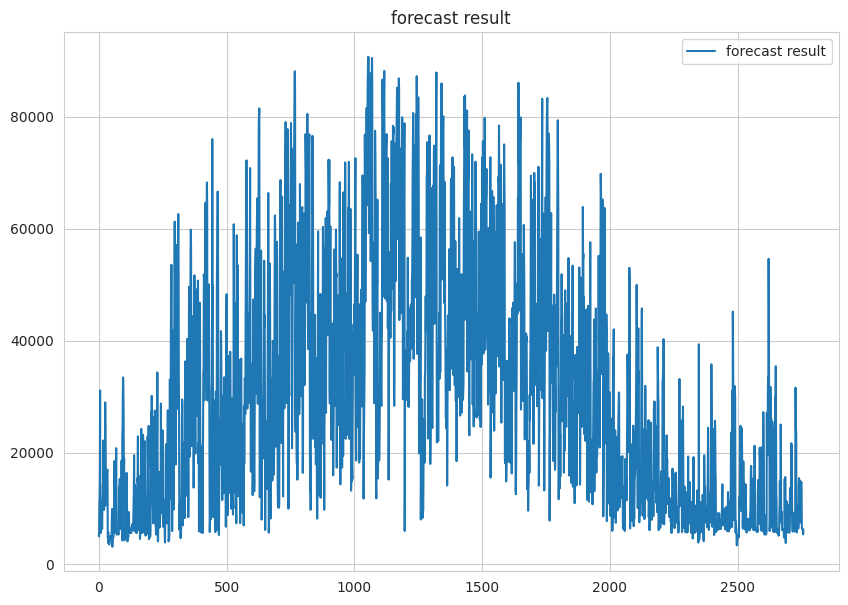

In [126]:
plt.figure(figsize=(10,7), dpi=100)
plt.plot(res, label='forecast result')
plt.legend(loc=1)
plt.title('forecast result' )
plt.show()

In [127]:
df_weather_actual_total.to_csv('weather_forecast_total_result.csv', index = False, header = True)

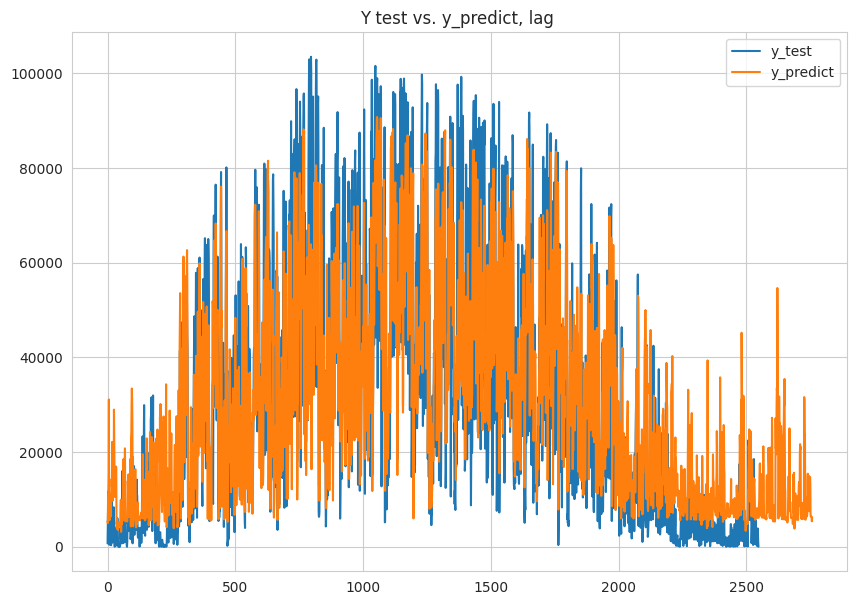

In [128]:
df_weather_actual = pd.read_csv('weather_actuals_prepared1.csv')
test = [x for x in df_weather_actual['Solar power']]
plot_res(test, res, label_test = 'y_test', label_score='y_predict')

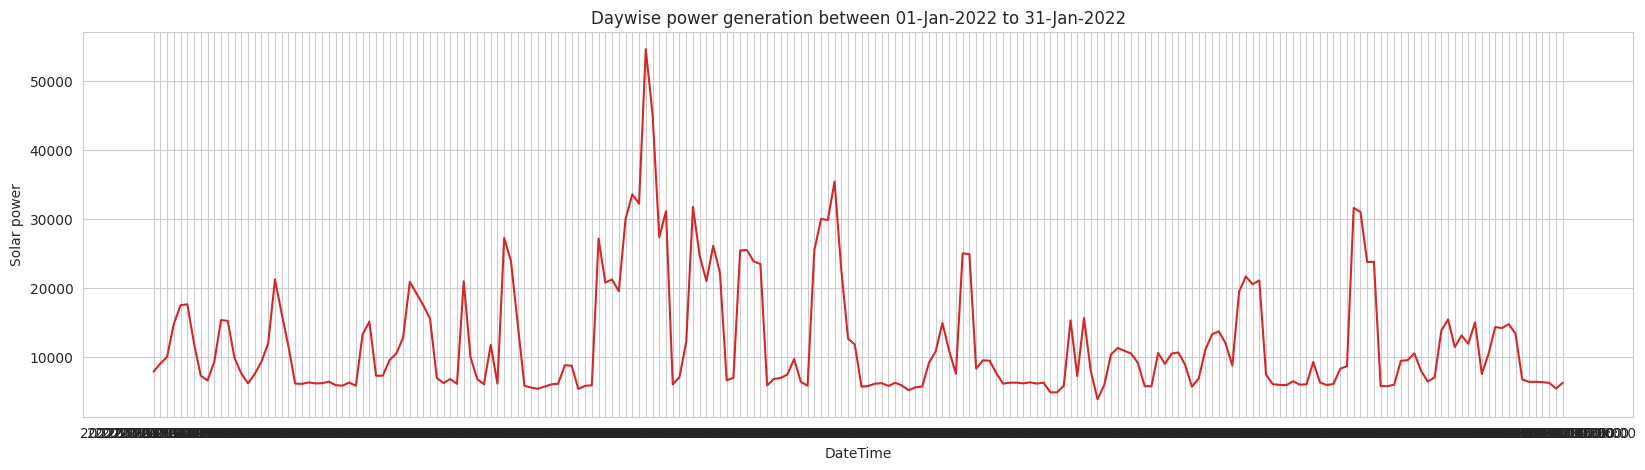

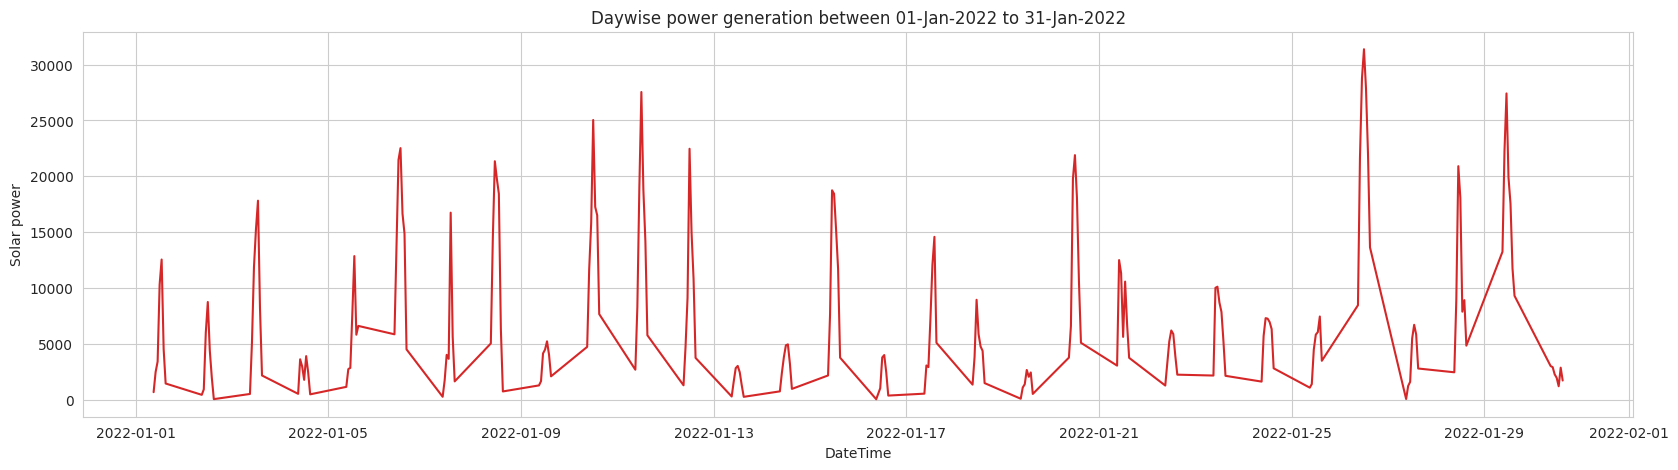

In [129]:
#df_forecast = pd.read_csv('Data/weather_forecast.csv')
start_date = '2022-01-01'
end_date = '2022-01-31'
mask = (df_weather_actual_total.datetime >= start_date) & (df_weather_actual_total.datetime <= end_date)
df_mask = df_weather_actual_total.loc[mask]

plot_df(df_mask, x=df_mask.datetime, y=df_mask.predicted_power, title='Daywise power generation between 01-Jan-2022 to 31-Jan-2022')
plot_df(df_weather_forecast, x=df_weather_forecast['datetime'], y=df_weather_forecast['Solar power'], title='Daywise power generation between 01-Jan-2022 to 31-Jan-2022')

df_weather_forecast['Predicted Solar power'] = [round(x,2) for x in df_mask.predicted_power]
#df_forecast.to_csv('forecast_result.csv')

In [130]:
#df_weather_forecast["Predicted Solar power"]

In [131]:
# Sample household consumption data (replace with your actual data)
household_consumption_data = {
    "hour": [9, 10, 11, 12, 13, 14, 15],
    "average_consumption": [720, 700, 610, 610, 600, 590, 580]
}

# Assuming df_weather_forecast has a date range from start_date to end_date
start_date = df_weather_forecast['datetime'].min().replace(hour=0, minute=0, second=0)
end_date = df_weather_forecast['datetime'].max().replace(hour=0, minute=0, second=0)

# Repeat household consumption data for each day in df_weather_forecast
consumption_data = []
for date in pd.date_range(start=start_date, end=end_date):
    for hour, consumption in zip(household_consumption_data['hour'], household_consumption_data['average_consumption']):
        consumption_data.append({
            'datetime': date + pd.Timedelta(hours=hour),
            'average_consumption': consumption
        })

# Create a DataFrame for household consumption
df_load_demand = pd.DataFrame(consumption_data)

# Print the DataFrame for household consumption
df_load_demand.head()


datetime  average_consumption
0 2022-01-01 09:00:00                  720
1 2022-01-01 10:00:00                  700
2 2022-01-01 11:00:00                  610
3 2022-01-01 12:00:00                  610
4 2022-01-01 13:00:00                  600

In [ ]:
# Merge the DataFrames based on 'datetime'
merged_df = pd.merge(df_weather_forecast, df_load_demand, on='datetime', how='inner')


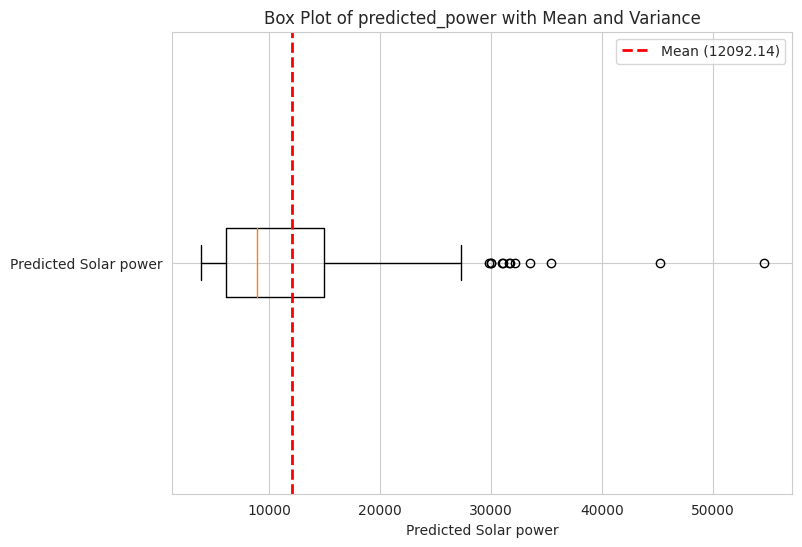

Mean Solar Power: 12092.13542857143
Variance Solar Power: 68469454.17928235


In [145]:

# Calculate mean and variance of predicted Solar power
mean_solar_power = merged_df['Predicted Solar power'].mean()
variance_solar_power = merged_df['Predicted Solar power'].var()

# Create a box plot for Solar power
plt.figure(figsize=(8, 6))
plt.boxplot(merged_df['Predicted Solar power'], vert=False, labels=['Predicted Solar power'])
plt.axvline(mean_solar_power, color='r', linestyle='dashed', linewidth=2, label=f'Mean ({mean_solar_power:.2f})')
plt.title('Box Plot of predicted_power with Mean and Variance')
plt.xlabel('Predicted Solar power')
plt.legend()
plt.show()

# Print the calculated mean and variance
print('Mean Solar Power:', mean_solar_power)
print('Variance Solar Power:', variance_solar_power)

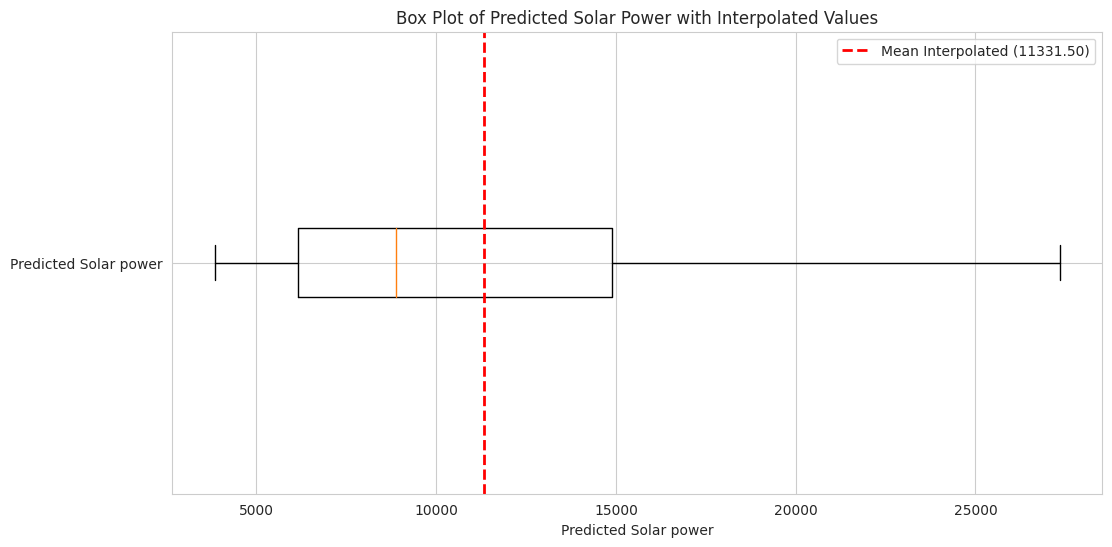

Mean Solar Power (Interpolated): 11331.498190476192
Variance Solar Power (Interpolated): 41236265.453580335


In [146]:
# Calculate quartiles for Predicted Solar power
Q1 = merged_df['Predicted Solar power'].quantile(0.25)
Q3 = merged_df['Predicted Solar power'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Set the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with NaN
merged_df.loc[(merged_df['Predicted Solar power'] < lower_bound) | (merged_df['Predicted Solar power'] > upper_bound), 'Predicted Solar power'] = np.nan

# Interpolate the NaN values using linear interpolation
merged_df['Predicted Solar power'] = merged_df['Predicted Solar power'].interpolate(method='linear')

# Calculate mean and variance after interpolation
mean_solar_power_interpolated = merged_df['Predicted Solar power'].mean()
variance_solar_power_interpolated = merged_df['Predicted Solar power'].var()

# Create a box plot for Solar power with interpolated values
plt.figure(figsize=(12, 6))
plt.boxplot(merged_df['Predicted Solar power'], vert=False, labels=['Predicted Solar power'])
plt.axvline(mean_solar_power_interpolated, color='r', linestyle='dashed', linewidth=2, label=f'Mean Interpolated ({mean_solar_power_interpolated:.2f})')
plt.title('Box Plot of Predicted Solar Power with Interpolated Values')
plt.xlabel('Predicted Solar power')
plt.legend()
plt.show()

# Print the calculated mean and variance after interpolation
print('Mean Solar Power (Interpolated):', mean_solar_power_interpolated)
print('Variance Solar Power (Interpolated):', variance_solar_power_interpolated)


In [165]:
# AEM Electrolyzer parameters
aem_power_max_per_hour = 2.59  # Maximum power consumption per AEM electrolyzer per hour in kWh
hydrogen_production_per_kwh = 0.545 # in m3

# Reduce Predicted Solar power by 5% to account for DC to AC conversion at 95% efficiency
merged_df['Predicted Solar power_AC'] = merged_df['Predicted Solar power'] * 0.95

# Calculate excess electricity for each hour using the adjusted Predicted Solar power
merged_df['Excess Electricity'] = merged_df['Predicted Solar power_AC'] - merged_df['average_consumption']
merged_df['Excess Electricity'] = merged_df['Excess Electricity'].clip(lower=0)  # Set negative values to 0


# Calculate the max number of AEM electrolyzers for each hour using the adjusted Excess Electricity
merged_df['max number of Electrolyzers'] = np.floor(merged_df['Excess Electricity'] / aem_power_max_per_hour)

# Calculate hydrogen production for each hour using optimal AEM electrolyzers
merged_df['Hydrogen Production'] = merged_df['max number of Electrolyzers'] * hydrogen_production_per_kwh

# Print the DataFrame with additional calculated columns
merged_df[['datetime', 'Predicted Solar power', 'average_consumption', 'Excess Electricity', 'max number of Electrolyzers', 'Hydrogen Production']]

datetime  Predicted Solar power  average_consumption  \
0   2022-01-01 09:00:00               7.842740                 0.72   
1   2022-01-01 10:00:00               9.011660                 0.70   
2   2022-01-01 11:00:00               9.982460                 0.61   
3   2022-01-01 12:00:00              14.777730                 0.61   
4   2022-01-01 13:00:00              17.482380                 0.60   
5   2022-01-01 14:00:00              17.615620                 0.59   
6   2022-01-01 15:00:00              11.910800                 0.58   
7   2022-01-02 09:00:00               7.243810                 0.72   
8   2022-01-02 10:00:00               6.562870                 0.70   
9   2022-01-02 11:00:00               9.275840                 0.61   
10  2022-01-02 12:00:00              15.329520                 0.61   
11  2022-01-02 13:00:00              15.204720                 0.60   
12  2022-01-02 14:00:00               9.814890                 0.59   
13  2022-01-02 15:00:00               7.592930                 0.58   
14  2022-01-03 09:00:00               6.138020                 0.72   
15  2022-01-03 10:00:00               7.510130                 0.70   
16  2022-01-03 11:00:00               9.285510                 0.61   
17  2022-01-03 12:00:00              11.986340                 0.61   
18  2022-01-03 13:00:00              21.211460                 0.60   
19  2022-01-03 14:00:00              16.243610                 0.59   
20  2022-01-03 15:00:00              11.504320                 0.58   
21  2022-01-04 09:00:00               6.105550                 0.72   
22  2022-01-04 10:00:00               6.068340                 0.70   
23  2022-01-04 11:00:00               6.275640                 0.61   
24  2022-01-04 12:00:00               6.136250                 0.61   
25  2022-01-04 13:00:00               6.161490                 0.60   
26  2022-01-04 14:00:00               6.388460                 0.59   
27  2022-01-04 15:00:00               5.873810                 0.58   
28  2022-01-05 09:00:00               5.804630                 0.72   
29  2022-01-05 10:00:00               6.250080                 0.70   
30  2022-01-05 11:00:00               5.809690                 0.61   
31  2022-01-05 12:00:00              13.240210                 0.61   
32  2022-01-05 13:00:00              15.102390                 0.60   
33  2022-01-05 14:00:00               7.232480                 0.59   
34  2022-01-05 15:00:00               7.258540                 0.58   
35  2022-01-06 09:00:00               9.531030                 0.72   
36  2022-01-06 10:00:00              10.477780                 0.70   
37  2022-01-06 11:00:00              12.752780                 0.61   
38  2022-01-06 12:00:00              20.870450                 0.61   
39  2022-01-06 13:00:00              19.160640                 0.60   
40  2022-01-06 14:00:00              17.469500                 0.59   
41  2022-01-06 15:00:00              15.525610                 0.58   
42  2022-01-07 09:00:00               6.938650                 0.72   
43  2022-01-07 10:00:00               6.175910                 0.70   
44  2022-01-07 11:00:00               6.765670                 0.61   
45  2022-01-07 12:00:00               6.068140                 0.61   
46  2022-01-07 13:00:00              20.953140                 0.60   
47  2022-01-07 14:00:00               9.939320                 0.59   
48  2022-01-07 15:00:00               6.774770                 0.58   
49  2022-01-08 09:00:00               6.003580                 0.72   
50  2022-01-08 10:00:00              11.718960                 0.70   
51  2022-01-08 11:00:00               6.097740                 0.61   
52  2022-01-08 12:00:00              27.238810                 0.61   
53  2022-01-08 13:00:00              23.887230                 0.60   
54  2022-01-08 14:00:00              14.833710                 0.59   
55  2022-01-08 15:00:00               5

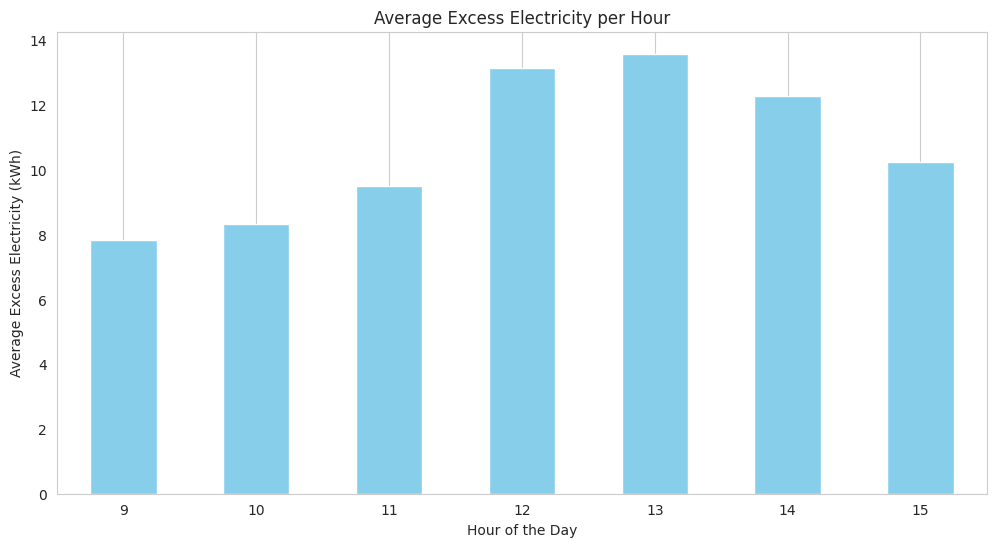

In [137]:
# Calculate hourly average of excess electricity
hourly_avg_excess_electricity = merged_df.groupby(merged_df['datetime'].dt.hour)['Excess Electricity'].mean()

# Plot the average excess electricity
plt.figure(figsize=(12, 6))
hourly_avg_excess_electricity.plot(kind='bar', color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Excess Electricity (kWh)')
plt.title('Average Excess Electricity per Hour')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


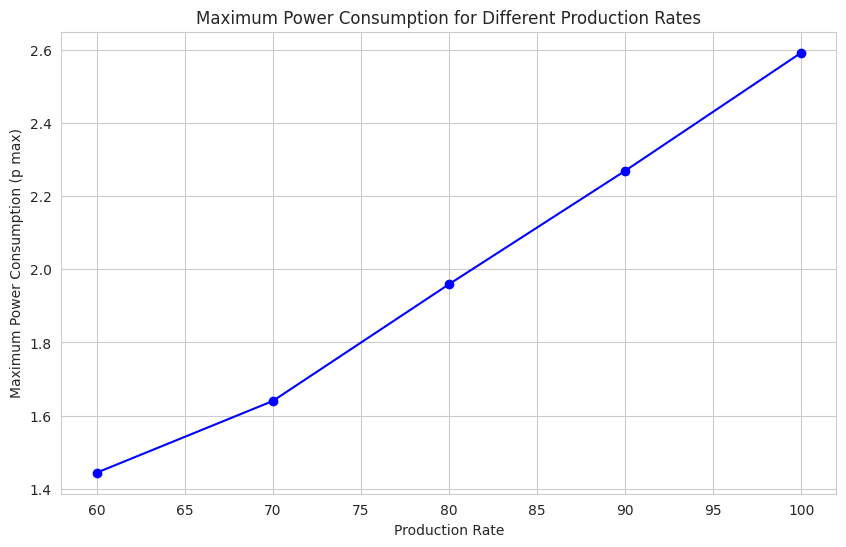

In [138]:
import matplotlib.pyplot as plt

# Production rates and corresponding maximum power consumption
production_rates = [100, 90, 80, 70, 60]
max_power_consumption = [2.592, 2.269, 1.959, 1.64, 1.444]

# Plot the maximum power consumption for different production rates
plt.figure(figsize=(10, 6))
plt.plot(production_rates, max_power_consumption, marker='o', linestyle='-', color='b')
plt.xlabel('Production Rate')
plt.ylabel('Maximum Power Consumption (p max)')
plt.title('Maximum Power Consumption for Different Production Rates')
plt.grid(True)
plt.show()


##Find the oprimum number of electrolyzer:
###First we check for the first day and then for the whole data

In [162]:
opt_df = merged_df.copy()

# Assuming opt_df is the DataFrame containing the relevant data

# Filter for the first day
#first_day_df = opt_df[opt_df['datetime'].dt.day == 1]

# Get unique 'max number of Electrolyzers' values
unique_max_electrolyzer_counts = opt_df['max number of Electrolyzers'].unique()

# Calculate the sum of absolute differences for each unique 'max number of Electrolyzers'
sum_absolute_differences = []
for count in unique_max_electrolyzer_counts:
    absolute_diff_sum = np.sum(np.abs(unique_max_electrolyzer_counts - count))
    sum_absolute_differences.append(absolute_diff_sum)

# Find the maximum 'max number of Electrolyzers' with the minimum sum of absolute differences
optimum_electrolyzer_count_first_day = unique_max_electrolyzer_counts[np.argmin(sum_absolute_differences)]

print("Optimum number of electrolyzers for the first day:", optimum_electrolyzer_count_first_day)



Optimum number of electrolyzers for the first day: 5.0


In [163]:
# Get unique 'max number of Electrolyzers'
unique_max_electrolyzers = opt_df['max number of Electrolyzers'].unique()

# Initialize variables to keep track of optimum values
optimum_electrolyzer_count = None
min_sum_of_differences = float('inf')

# Iterate through unique 'max number of Electrolyzers'
for max_electrolyzer_count in unique_max_electrolyzers:
    # Calculate sum of absolute differences
    sum_of_differences = np.sum(np.abs(unique_max_electrolyzers - max_electrolyzer_count))

    # Check if this is a better optimum
    if sum_of_differences < min_sum_of_differences:
        min_sum_of_differences = sum_of_differences
        optimum_electrolyzer_count = max_electrolyzer_count

print("Optimum number of electrolyzers:", optimum_electrolyzer_count)


Optimum number of electrolyzers: 5.0


In [171]:
# Assuming opt_df is the DataFrame containing the relevant data

# Calculate absolute difference
opt_df['number_of_ON_electrolyzer'] = np.abs(opt_df['max number of Electrolyzers'] - optimum_electrolyzer_count)

# Apply the conditions to determine 'number_of_ON_electrolyzer' for each row
opt_df['number_of_ON_electrolyzer'] = np.where(
    opt_df['max number of Electrolyzers'] <= optimum_electrolyzer_count,
    opt_df['max number of Electrolyzers'],
    optimum_electrolyzer_count
)

print(opt_df[['max number of Electrolyzers', 'number_of_ON_electrolyzer']].head())


   max number of Electrolyzers  number_of_ON_electrolyzer
0                          2.0                        2.0
1                          3.0                        3.0
2                          3.0                        3.0
3                          5.0                        5.0
4                          6.0                        5.0


In [173]:

# Hydrogen production per hour per electrolyzer in m3
hydrogen_production_per_hour_per_electrolyzer = 0.545

# Calculate hydrogen production for each row based on 'number_of_ON_electrolyzer'
opt_df['Hydrogen Production'] = opt_df['number_of_ON_electrolyzer'] * hydrogen_production_per_hour_per_electrolyzer

print(opt_df[['number_of_ON_electrolyzer', 'Hydrogen Production']].head())


   number_of_ON_electrolyzer  Hydrogen Production
0                        2.0                1.090
1                        3.0                1.635
2                        3.0                1.635
3                        5.0                2.725
4                        5.0                2.725


In [175]:
import pandas as pd

# Assuming opt_df is the DataFrame containing the relevant data

# Calculate hydrogen production per hour per electrolyzer in m3
hydrogen_production_per_hour_per_electrolyzer = 0.545

# Calculate hydrogen production for each row based on 'number_of_ON_electrolyzer'
opt_df['Hydrogen Production'] = opt_df['number_of_ON_electrolyzer'] * hydrogen_production_per_hour_per_electrolyzer

# Group by date and sum the hydrogen production for each day
daily_hydrogen_production = opt_df.groupby(opt_df['datetime'].dt.date)['Hydrogen Production'].sum()

print("Hydrogen production per day:")
print(daily_hydrogen_production)


Hydrogen production per day:
datetime
2022-01-01    14.715
2022-01-02    11.990
2022-01-03    13.625
2022-01-04     7.630
2022-01-05     9.810
2022-01-06    16.350
2022-01-07     9.810
2022-01-08    13.625
2022-01-09     7.085
2022-01-10    13.080
2022-01-11    19.075
2022-01-12    15.260
2022-01-13    15.805
2022-01-14     7.630
2022-01-15    17.985
2022-01-16     5.995
2022-01-17     9.265
2022-01-18    11.990
2022-01-19     7.630
2022-01-20     9.810
2022-01-21     9.810
2022-01-22     9.265
2022-01-23    12.535
2022-01-24    14.170
2022-01-25     7.630
2022-01-26    14.715
2022-01-27     8.175
2022-01-28    14.170
2022-01-29    15.805
2022-01-30     7.085
Name: Hydrogen Production, dtype: float64


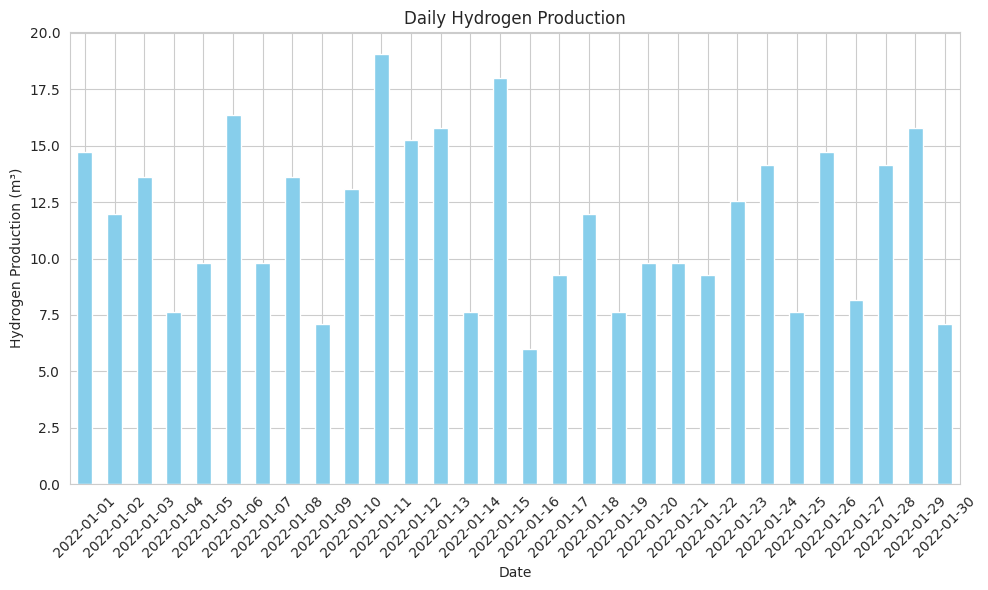

In [176]:
# Plotting the daily hydrogen production
plt.figure(figsize=(10, 6))
daily_hydrogen_production.plot(kind='bar', color='skyblue')
plt.xlabel('Date')
plt.ylabel('Hydrogen Production (m³)')
plt.title('Daily Hydrogen Production')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

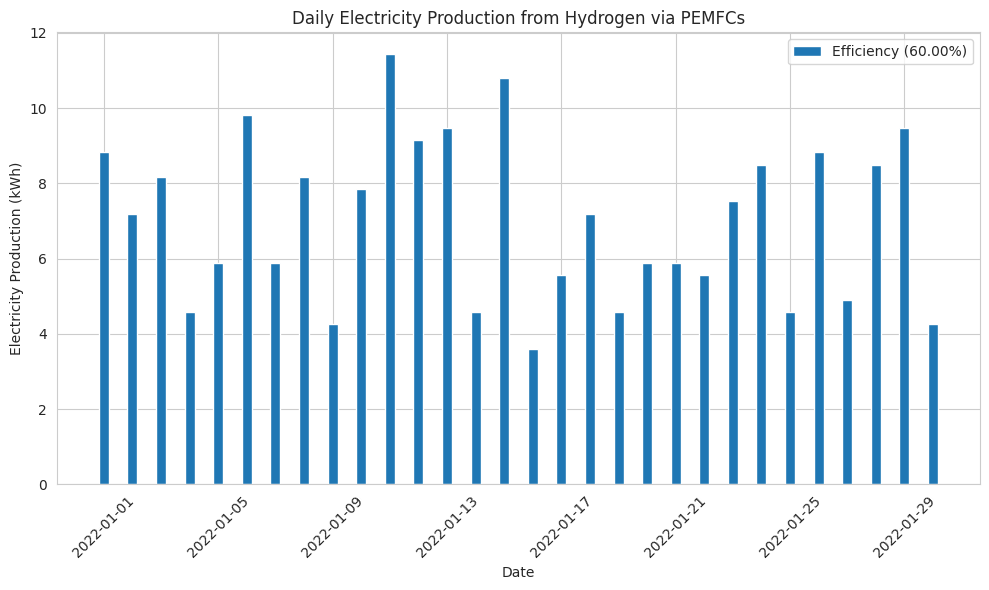

In [180]:
import numpy as np

# Assuming daily_hydrogen_production is the Series containing daily hydrogen production

# Efficiency range for a PEMFC fuel cell
efficiency = 0.6

# Calculate electricity produced for each day within the efficiency range
electricity_produced = daily_hydrogen_production * efficiency


# Dates for x-axis
dates = daily_hydrogen_production.index

# Width of the bars
bar_width = 0.35

# Plotting the daily electricity production within the efficiency range as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(dates, electricity_produced, width=bar_width, label=f'Efficiency ({efficiency* 100:.2f}%)')

plt.xlabel('Date')
plt.ylabel('Electricity Production (kWh)')
plt.title('Daily Electricity Production from Hydrogen via PEMFCs')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [181]:
# Filter for the first day
first_day_schedule = opt_df[opt_df['datetime'].dt.day == 1]

print("Schedule for the electrolyzers for each hour of the first day:")
print(first_day_schedule[['datetime', 'number_of_ON_electrolyzer', 'Hydrogen Production']])

Schedule for the electrolyzers for each hour of the first day:
             datetime  number_of_ON_electrolyzer  Hydrogen Production
0 2022-01-01 09:00:00                        2.0                1.090
1 2022-01-01 10:00:00                        3.0                1.635
2 2022-01-01 11:00:00                        3.0                1.635
3 2022-01-01 12:00:00                        5.0                2.725
4 2022-01-01 13:00:00                        5.0                2.725
5 2022-01-01 14:00:00                        5.0                2.725
6 2022-01-01 15:00:00                        4.0                2.180


In [ ]:
import requests
import datetime
import sched
import time
import pandas as pd

# Replace with your Enapter gateway endpoint and telemetry ID
ENAPTER_GATEWAY_ENDPOINT = "http://enapter-gateway.local/api"
TELEMETRY_ID = "07940993-54c4-43a3-af63-1f8289373d4d"

# Sample household consumption data (replace with your actual data)
# Assuming you have a DataFrame 'df_weather_forecast' with predicted solar power
# Replace this with your actual DataFrame and column names

# Function to get predicted solar power for a given hour
def get_predicted_solar_power(hour):
    # Get the predicted DC solar power
    predicted_dc_power = df_weather_forecast[df_weather_forecast['datetime'].dt.hour == hour]['Predicted Solar power'].values
    predicted_dc_power = predicted_dc_power[0] if predicted_dc_power else 0

    # Convert the predicted DC power to AC considering 95% efficiency
    predicted_ac_power = predicted_dc_power / 0.95

    return predicted_ac_power

# Function to send a turn-on command to Enapter electrolyzer
def send_start_electrolyzer_command():
    url = f"{ENAPTER_GATEWAY_ENDPOINT}/gateway/{TELEMETRY_ID}/start-els"
    response = requests.post(url)
    return response.json()

# Function to check and start electrolyzer based on predictions
def start_electrolyzer(sc, schedule_df):
    # Get the current hour
    current_hour = datetime.datetime.now().hour

    # Assuming you have predicted solar power for the next three days
    predicted_ac_power = get_predicted_solar_power(current_hour)

    # Find the household consumption data for the current hour
    household_consumption = df_household_consumption[df_household_consumption['datetime'].dt.hour == current_hour]['average_consumption'].values
    household_consumption = household_consumption[0] if household_consumption else 0

    # Considering Enapter AEM electrolyzer's 95% AC to DC efficiency
    predicted_dc_power_for_electrolyzer = predicted_ac_power * 0.95

    # Check if electrolyzer is turned on
    electrolyzer_on = predicted_dc_power_for_electrolyzer > household_consumption

    # Update the schedule DataFrame
    schedule_df = schedule_df.append({'datetime': datetime.datetime.now(), 'electrolyzer_on': electrolyzer_on}, ignore_index=True)

    if electrolyzer_on:
        # Send start-els command to Enapter electrolyzer
        send_start_electrolyzer_command()
        print(f"Hour: {current_hour}, Predicted Solar Power (DC for electrolyzer): {predicted_dc_power_for_electrolyzer}, Household Consumption: {household_consumption}")
        print("Enapter electrolyzer started successfully.")
    else:
        print(f"Hour: {current_hour}, Predicted Solar Power (DC for electrolyzer): {predicted_dc_power_for_electrolyzer}, Household Consumption: {household_consumption}")
        print("Sufficient solar power not available for hydrogen production.")

    # Schedule the next check at the next hour
    sc.enter(3600, 1, start_electrolyzer, (sc, schedule_df))

# Initialize the scheduler
scheduler = sched.scheduler(time.time, time.sleep)

# Initialize an empty DataFrame to store the schedule
schedule_df = pd.DataFrame(columns=['datetime', 'electrolyzer_on'])

# Schedule the first check to start now
scheduler.enter(0, 1, start_electrolyzer, (scheduler, schedule_df))

# Start the scheduler
#scheduler.run()

# Print the schedule DataFrame
print("Schedule:")
schedule_df
